# Pleiothropy all tasks

#### Data Preprocessing:
- merge all pedgree ID's 
- build a unique Pedigree
- merge all pheno files according the unique pedgree

#### Pleiothropy estimate:
- loop over pheno and estimate pleiothropy between each pair of pheno
- collect results in a dictionary of matrix:
    - pleio Matrix rhoG
    - P-value Matrix of rhoG different from 0
    - P-value Matrix of rhoG d
    ifferent from 1
    - pleio Matrix RhoE
    - P-value Matrix of RhoE different from 0
    - P-value Matrix of RhoE different from 1

#### Clutering Rho Matrices :
- cluster pleio Matrix rhoG
- plot clustered pleio Matrix rhoG
- plot clustered P-value Matrix of rhoG different from 0
- plot clustered P-value Matrix of rhoG different from 1
- cluster pleio Matrix RhoE
- plot clustered pleio Matrix RhoE
- plot clustered P-value Matrix of RhoE different from 0
- plot clustered P-value Matrix of RhoE different from 1

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import time
import seaborn as sns
import functools
import subprocess as subp
from nilearn import plotting as nlp
from scipy import cluster as scl
from scipy import io as sio
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec as gs
import itertools
import datetime
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import collections
import multiprocessing 
import datetime
import sys


In [2]:
def make_boxes(mat, cl_def, pad=1, edge=False):
    """
    mat:    the matrix you want to do stuff to
    cl_def: a list of tuples where the first position is the 
            index of the first element in the cluster. the 
            second position is the index of the last element 
            in the cluster
    pad:    an integer value for the number of zero spaces to add
            around clusters
    edge:   boolean argument. If True, clusters at the corners will
            be drawn full. If False, clusters will be only drawn on
            the inside edge (no white line around the matrix).
            
    returns:
    omat:   the input matrix with the spaces added
    cmat_m: the overlayed cluster boxes in a masked array
    lmat_m: a mask of the added empty spaces
    ind:    the new index positions for the data (for x_ticks...)
    """
    # Extract the values
    starts = [i[0] for i in cl_def if not i[0]==0]
    if edge:
        starts = [i[0] for i in cl_def]
        stops = [i[1]+1 for i in cl_def]
    else:
        starts = [i[0] for i in cl_def if not i[0]==0]
        stops = [i[1]+1 for i in cl_def if not i[1]+1>=mat.shape[0]]
    # Find the breakpoints
    bkp = list(np.unique(starts + stops))
    n_bkp = len(bkp)
    # Convert to new indices
    run = 0
    ind = list()
    for i in np.arange(mat.shape[0]):
        if i in bkp:
            run += pad
        ind.append(i+run)

    # Make indices
    x = [i[0] for i in itertools.product(ind, ind)]
    y = [i[1] for i in itertools.product(ind, ind)]

    # Make new matrix
    omat = np.zeros([i+n_bkp*pad for i in mat.shape])
    omat[x, y] = mat.flatten()

    # Make a matrix for the clusters
    cmat = np.zeros_like(omat)
    # Make a matrix for the empty lines
    lmat = np.zeros_like(omat, dtype=bool)
    lmat[x,y] = True
    lmat_m = np.ma.masked_where(lmat, lmat)
    # Convert the input based breakpoints
    starts_c = [ind[i[0]]-pad for i in cl_def]
    stops_c = [ind[i[1]]+1 for i in cl_def]
    for i in np.arange(len(starts_c)):
        start = starts_c[i]
        stop = stops_c[i]
        if pad==1:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
        else:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
            
        if not start<=0 or edge:
            # Draw the top left corner first
            cmat[start_ind, start:stop] = i+1
            cmat[start:stop, start_ind] = i+1
        else:
            # Draw the bottom right corner next
            cmat[stop_ind, :stop+pad] = i+1
            cmat[:stop+pad, stop_ind] = i+1
            continue
        if not stop>=omat.shape[0] or edge:
            # Draw the bottom right corner next
            cmat[stop_ind, start:stop+pad] = i+1
            cmat[start:stop+pad, stop_ind] = i+1
    cmat_m = np.ma.masked_where(cmat==0, cmat)
    return omat, cmat_m, lmat_m, ind

In [3]:
%matplotlib inline

In [6]:
# Set path 
path_pheno = '/home/yassinebha/data/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/pheno/'
path_root = '/scratch/yassinebha/pleio/'

# Load files
pedig_df = pd.read_csv(os.path.join(path_root,'solar_Rest1_LR_pedigre.csv'))
pheno_df =  pd.read_csv(os.path.join(path_pheno,'hcp_all_pheno_clean_nonan_norm_1200.csv'),
                        dtype={'Unnamed: 0':str}).rename(columns={'Unnamed: 0' : 'ID'})

# add HCP prefix to pheno file ID's
pheno_df['ID'] = ['HCP'+row.ID for idx,row in pheno_df.iterrows()]

In [7]:
pheno_df.head()

,ID,Handedness,BMI,BPSystolic,BPDiastolic,PSQI_Score,PicSeq_Unadj,CardSort_Unadj,Flanker_Unadj,PMAT24_A_CR,...,ASR_Rule_T,ASR_Intr_T,ASR_Intn_T,ASR_Extn_T,DSM_Depr_T,DSM_Anxi_T,DSM_Somp_T,DSM_Avoid_T,DSM_Adh_T,DSM_Antis_T
0,HCP100004,0.648359,-0.244816,0.764090,0.007427,1.133314,0.528681,-1.120047,1.031664,0.479529,...,-0.559403,-0.152135,0.871283,0.571571,0.860094,-0.445573,-0.698145,1.560611,-0.329000,1.862940
1,HCP100206,-0.030594,-0.036775,-0.354362,-0.539651,0.417471,0.999300,0.411412,1.866864,0.683727,...,0.586885,1.117440,1.987636,1.132640,2.236722,1.440675,2.519750,2.049998,1.570192,0.821152
2,HCP100307,0.648359,-0.702506,-0.494169,-0.630831,-0.298371,-0.069013,0.853493,0.101578,0.071133,...,-0.559403,-0.696239,-0.896274,-0.326140,-0.688612,-0.634198,-0.698145,-0.723196,-0.674307,-0.428993
3,HCP100408,-0.256912,0.164029,1.952446,1.557482,-0.298371,1.046583,-0.355756,0.953581,-1.970847,...,0.395837,-0.696239,-0.989303,-0.213926,-0.688612,-0.445573,-0.698145,-0.723196,-0.674307,-0.428993
4,HCP100610,0.422041,1.821119,1.183510,-0.174932,-0.298371,-0.185005,1.437499,1.482376,1.296321,...,-0.750451,-0.152135,0.406137,-0.326140,-0.688612,-0.634198,-0.698145,2.539386,-0.846961,-0.637350


In [8]:
# clean pheno file according to pedig file
pheno_clean_df = pd.merge(pedig_df[['ID']],pheno_df.drop(columns=['Handedness', 'Odor_Unadj']),how='left',on='ID').dropna()

pheno_clean_df.head()

,ID,BMI,BPSystolic,BPDiastolic,PSQI_Score,PicSeq_Unadj,CardSort_Unadj,Flanker_Unadj,PMAT24_A_CR,PMAT24_A_RTCR,...,ASR_Rule_T,ASR_Intr_T,ASR_Intn_T,ASR_Extn_T,DSM_Depr_T,DSM_Anxi_T,DSM_Somp_T,DSM_Avoid_T,DSM_Adh_T,DSM_Antis_T
0,HCP100206,-0.036775,-0.354362,-0.539651,0.417471,0.999300,0.411412,1.866864,0.683727,0.334611,...,0.586885,1.117440,1.987636,1.132640,2.236722,1.440675,2.519750,2.049998,1.570192,0.821152
1,HCP100307,-0.702506,-0.494169,-0.630831,-0.298371,-0.069013,0.853493,0.101578,0.071133,-0.394380,...,-0.559403,-0.696239,-0.896274,-0.326140,-0.688612,-0.634198,-0.698145,-0.723196,-0.674307,-0.428993
2,HCP100408,0.164029,1.952446,1.557482,-0.298371,1.046583,-0.355756,0.953581,-1.970847,-1.346490,...,0.395837,-0.696239,-0.989303,-0.213926,-0.688612,-0.445573,-0.698145,-0.723196,-0.674307,-0.428993
3,HCP100610,1.821119,1.183510,-0.174932,-0.298371,-0.185005,1.437499,1.482376,1.296321,-0.346650,...,-0.750451,-0.152135,0.406137,-0.326140,-0.688612,-0.634198,-0.698145,2.539386,-0.846961,-0.637350
4,HCP101006,0.619910,0.414574,0.919224,-1.014213,-1.984735,-0.926337,-0.957001,-1.154055,-0.964758,...,-0.368355,-0.696239,-1.175362,-0.213926,-0.688612,-0.634198,-0.698145,-0.723196,-0.846961,-0.637350


In [9]:
# Save pheno clean 
pheno_clean_df.to_csv(os.path.join(path_root,'hcp_all_pheno_clean_nonan_norm_pleio_1200.csv'),index=False)

### Pleiothropy estimate:

In [10]:
#initiate empty dictionary
Pleio_RhoG = collections.namedtuple('Pleio_RhoG', ['out_dir',
                                                   'pedig_f',
                                                   'pheno_f',
                                                   'var_1',
                                                   'var_2'
                                                  ])
pleio_RhoGs = []

# pleio root folder
path_pleio = os.path.join(path_root,'pleio_{}'.format(str(datetime.date.today())))
if not os.path.exists(path_pleio):
    os.makedirs(path_pleio)

# create ouput folders and populate RhoG dictionnary
for ix_pheno_1, pheno_1 in enumerate(pheno_clean_df.columns.drop('ID')):
    for ix_pheno_2, pheno_2 in enumerate(pheno_clean_df.columns.drop('ID')):
        if pheno_1  == pheno_2:
            continue
        print(pheno_1,pheno_2)
        
        # output result folder 
        path_pleio_contrast = os.path.join(path_pleio,'{}_{}'.format(pheno_1,pheno_2))
        if not os.path.exists(path_pleio_contrast):
            os.makedirs(path_pleio_contrast)
            
        # copy needed files to output folder
        if not os.path.isfile(os.path.join(path_pleio_contrast,'se_univ_polygen.tcl')):
            subp.run(['cp',os.path.join(path_root,'se_univ_polygen.tcl'),path_pleio_contrast])
        if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_pheno_run.sh')):
            subp.run(['cp',os.path.join(path_root,'pleio_pheno_run.sh'),path_pleio_contrast])
            
        # pedegree
        if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')):
            subp.run(['cp',os.path.join(path_root,'pleio_all_pheno_pedig.csv'),path_pleio_contrast]) 
            
        pedig_f = os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')
        
        # pheno cov stack
        df_pheno = pheno_clean_df[['ID',pheno_1,pheno_2]]
        #cov_1 = '{}_FD_scrubbed_mean'.format(pheno_1.split('_')[0])
        #cov_2 = '{}_FD_scrubbed_mean'.format(pheno_2.split('_')[0])
        #df_cov = cov_stack_FD_df[['ID',cov_1,cov_2]]
        #pheno_cov_stack = [df_pheno,df_cov,cov_stack_stand_df]
        
        # merge pheno cov
        #pheno_cov_df = functools.reduce(lambda left,right: pd.merge(left,right,on='ID',how='inner'), 
        #                                pheno_cov_stack)
        # save pheno cov to file
        pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
        if not os.path.isfile(pheno_f):
            df_pheno.to_csv(pheno_f,index=False)   
        
        # collect all pleio contrasts in dictionary
        pleio_RhoGs.append(Pleio_RhoG(out_dir = path_pleio_contrast,
                                      pedig_f = pedig_f,
                                      pheno_f = pheno_f,
                                      var_1 = pheno_1,
                                      var_2 = pheno_2)) 

BMI BPSystolic
BMI BPDiastolic
BMI PSQI_Score
BMI PicSeq_Unadj
BMI CardSort_Unadj
BMI Flanker_Unadj
BMI PMAT24_A_CR
BMI PMAT24_A_RTCR
BMI ReadEng_Unadj
BMI PicVocab_Unadj
BMI ProcSpeed_Unadj
BMI DDisc_AUC_200
BMI DDisc_AUC_40K
BMI VSPLOT_TC
BMI VSPLOT_CRTE
BMI SCPT_TP
BMI SCPT_TN
BMI SCPT_TPRT
BMI IWRD_TOT
BMI IWRD_RTC
BMI ER40_CR
BMI ER40_CRT
BMI Sadness_Unadj
BMI FearSomat_Unadj
BMI FearAffect_Unadj
BMI AngAggr_Unadj
BMI AngHostil_Unadj
BMI AngAffect_Unadj
BMI LifeSatisf_Unadj
BMI MeanPurp_Unadj
BMI PosAffect_Unadj
BMI Friendship_Unadj
BMI Loneliness_Unadj
BMI PercHostil_Unadj
BMI PercReject_Unadj
BMI EmotSupp_Unadj
BMI InstruSupp_Unadj
BMI PercStress_Unadj
BMI SelfEff_Unadj
BMI PainInterf_Tscore
BMI Taste_Unadj
BMI Mars_Final
BMI GaitSpeed_Comp
BMI Dexterity_Unadj
BMI Strength_Unadj
BMI NEOFAC_A
BMI NEOFAC_O
BMI NEOFAC_C
BMI NEOFAC_N
BMI NEOFAC_E
BMI ASR_Anxd_Pct
BMI ASR_Witd_T
BMI ASR_Soma_T
BMI ASR_Thot_T
BMI ASR_Attn_T
BMI ASR_Aggr_T
BMI ASR_Rule_T
BMI ASR_Intr_T
BMI ASR_Intn_T
B

CardSort_Unadj LifeSatisf_Unadj
CardSort_Unadj MeanPurp_Unadj
CardSort_Unadj PosAffect_Unadj
CardSort_Unadj Friendship_Unadj
CardSort_Unadj Loneliness_Unadj
CardSort_Unadj PercHostil_Unadj
CardSort_Unadj PercReject_Unadj
CardSort_Unadj EmotSupp_Unadj
CardSort_Unadj InstruSupp_Unadj
CardSort_Unadj PercStress_Unadj
CardSort_Unadj SelfEff_Unadj
CardSort_Unadj PainInterf_Tscore
CardSort_Unadj Taste_Unadj
CardSort_Unadj Mars_Final
CardSort_Unadj GaitSpeed_Comp
CardSort_Unadj Dexterity_Unadj
CardSort_Unadj Strength_Unadj
CardSort_Unadj NEOFAC_A
CardSort_Unadj NEOFAC_O
CardSort_Unadj NEOFAC_C
CardSort_Unadj NEOFAC_N
CardSort_Unadj NEOFAC_E
CardSort_Unadj ASR_Anxd_Pct
CardSort_Unadj ASR_Witd_T
CardSort_Unadj ASR_Soma_T
CardSort_Unadj ASR_Thot_T
CardSort_Unadj ASR_Attn_T
CardSort_Unadj ASR_Aggr_T
CardSort_Unadj ASR_Rule_T
CardSort_Unadj ASR_Intr_T
CardSort_Unadj ASR_Intn_T
CardSort_Unadj ASR_Extn_T
CardSort_Unadj DSM_Depr_T
CardSort_Unadj DSM_Anxi_T
CardSort_Unadj DSM_Somp_T
CardSort_Unadj DSM_

PicVocab_Unadj SCPT_TN
PicVocab_Unadj SCPT_TPRT
PicVocab_Unadj IWRD_TOT
PicVocab_Unadj IWRD_RTC
PicVocab_Unadj ER40_CR
PicVocab_Unadj ER40_CRT
PicVocab_Unadj Sadness_Unadj
PicVocab_Unadj FearSomat_Unadj
PicVocab_Unadj FearAffect_Unadj
PicVocab_Unadj AngAggr_Unadj
PicVocab_Unadj AngHostil_Unadj
PicVocab_Unadj AngAffect_Unadj
PicVocab_Unadj LifeSatisf_Unadj
PicVocab_Unadj MeanPurp_Unadj
PicVocab_Unadj PosAffect_Unadj
PicVocab_Unadj Friendship_Unadj
PicVocab_Unadj Loneliness_Unadj
PicVocab_Unadj PercHostil_Unadj
PicVocab_Unadj PercReject_Unadj
PicVocab_Unadj EmotSupp_Unadj
PicVocab_Unadj InstruSupp_Unadj
PicVocab_Unadj PercStress_Unadj
PicVocab_Unadj SelfEff_Unadj
PicVocab_Unadj PainInterf_Tscore
PicVocab_Unadj Taste_Unadj
PicVocab_Unadj Mars_Final
PicVocab_Unadj GaitSpeed_Comp
PicVocab_Unadj Dexterity_Unadj
PicVocab_Unadj Strength_Unadj
PicVocab_Unadj NEOFAC_A
PicVocab_Unadj NEOFAC_O
PicVocab_Unadj NEOFAC_C
PicVocab_Unadj NEOFAC_N
PicVocab_Unadj NEOFAC_E
PicVocab_Unadj ASR_Anxd_Pct
PicVo

VSPLOT_TC DSM_Somp_T
VSPLOT_TC DSM_Avoid_T
VSPLOT_TC DSM_Adh_T
VSPLOT_TC DSM_Antis_T
VSPLOT_CRTE BMI
VSPLOT_CRTE BPSystolic
VSPLOT_CRTE BPDiastolic
VSPLOT_CRTE PSQI_Score
VSPLOT_CRTE PicSeq_Unadj
VSPLOT_CRTE CardSort_Unadj
VSPLOT_CRTE Flanker_Unadj
VSPLOT_CRTE PMAT24_A_CR
VSPLOT_CRTE PMAT24_A_RTCR
VSPLOT_CRTE ReadEng_Unadj
VSPLOT_CRTE PicVocab_Unadj
VSPLOT_CRTE ProcSpeed_Unadj
VSPLOT_CRTE DDisc_AUC_200
VSPLOT_CRTE DDisc_AUC_40K
VSPLOT_CRTE VSPLOT_TC
VSPLOT_CRTE SCPT_TP
VSPLOT_CRTE SCPT_TN
VSPLOT_CRTE SCPT_TPRT
VSPLOT_CRTE IWRD_TOT
VSPLOT_CRTE IWRD_RTC
VSPLOT_CRTE ER40_CR
VSPLOT_CRTE ER40_CRT
VSPLOT_CRTE Sadness_Unadj
VSPLOT_CRTE FearSomat_Unadj
VSPLOT_CRTE FearAffect_Unadj
VSPLOT_CRTE AngAggr_Unadj
VSPLOT_CRTE AngHostil_Unadj
VSPLOT_CRTE AngAffect_Unadj
VSPLOT_CRTE LifeSatisf_Unadj
VSPLOT_CRTE MeanPurp_Unadj
VSPLOT_CRTE PosAffect_Unadj
VSPLOT_CRTE Friendship_Unadj
VSPLOT_CRTE Loneliness_Unadj
VSPLOT_CRTE PercHostil_Unadj
VSPLOT_CRTE PercReject_Unadj
VSPLOT_CRTE EmotSupp_Unadj
VSPLOT_CR

IWRD_RTC Mars_Final
IWRD_RTC GaitSpeed_Comp
IWRD_RTC Dexterity_Unadj
IWRD_RTC Strength_Unadj
IWRD_RTC NEOFAC_A
IWRD_RTC NEOFAC_O
IWRD_RTC NEOFAC_C
IWRD_RTC NEOFAC_N
IWRD_RTC NEOFAC_E
IWRD_RTC ASR_Anxd_Pct
IWRD_RTC ASR_Witd_T
IWRD_RTC ASR_Soma_T
IWRD_RTC ASR_Thot_T
IWRD_RTC ASR_Attn_T
IWRD_RTC ASR_Aggr_T
IWRD_RTC ASR_Rule_T
IWRD_RTC ASR_Intr_T
IWRD_RTC ASR_Intn_T
IWRD_RTC ASR_Extn_T
IWRD_RTC DSM_Depr_T
IWRD_RTC DSM_Anxi_T
IWRD_RTC DSM_Somp_T
IWRD_RTC DSM_Avoid_T
IWRD_RTC DSM_Adh_T
IWRD_RTC DSM_Antis_T
ER40_CR BMI
ER40_CR BPSystolic
ER40_CR BPDiastolic
ER40_CR PSQI_Score
ER40_CR PicSeq_Unadj
ER40_CR CardSort_Unadj
ER40_CR Flanker_Unadj
ER40_CR PMAT24_A_CR
ER40_CR PMAT24_A_RTCR
ER40_CR ReadEng_Unadj
ER40_CR PicVocab_Unadj
ER40_CR ProcSpeed_Unadj
ER40_CR DDisc_AUC_200
ER40_CR DDisc_AUC_40K
ER40_CR VSPLOT_TC
ER40_CR VSPLOT_CRTE
ER40_CR SCPT_TP
ER40_CR SCPT_TN
ER40_CR SCPT_TPRT
ER40_CR IWRD_TOT
ER40_CR IWRD_RTC
ER40_CR ER40_CRT
ER40_CR Sadness_Unadj
ER40_CR FearSomat_Unadj
ER40_CR FearAffect

FearAffect_Unadj ASR_Witd_T
FearAffect_Unadj ASR_Soma_T
FearAffect_Unadj ASR_Thot_T
FearAffect_Unadj ASR_Attn_T
FearAffect_Unadj ASR_Aggr_T
FearAffect_Unadj ASR_Rule_T
FearAffect_Unadj ASR_Intr_T
FearAffect_Unadj ASR_Intn_T
FearAffect_Unadj ASR_Extn_T
FearAffect_Unadj DSM_Depr_T
FearAffect_Unadj DSM_Anxi_T
FearAffect_Unadj DSM_Somp_T
FearAffect_Unadj DSM_Avoid_T
FearAffect_Unadj DSM_Adh_T
FearAffect_Unadj DSM_Antis_T
AngAggr_Unadj BMI
AngAggr_Unadj BPSystolic
AngAggr_Unadj BPDiastolic
AngAggr_Unadj PSQI_Score
AngAggr_Unadj PicSeq_Unadj
AngAggr_Unadj CardSort_Unadj
AngAggr_Unadj Flanker_Unadj
AngAggr_Unadj PMAT24_A_CR
AngAggr_Unadj PMAT24_A_RTCR
AngAggr_Unadj ReadEng_Unadj
AngAggr_Unadj PicVocab_Unadj
AngAggr_Unadj ProcSpeed_Unadj
AngAggr_Unadj DDisc_AUC_200
AngAggr_Unadj DDisc_AUC_40K
AngAggr_Unadj VSPLOT_TC
AngAggr_Unadj VSPLOT_CRTE
AngAggr_Unadj SCPT_TP
AngAggr_Unadj SCPT_TN
AngAggr_Unadj SCPT_TPRT
AngAggr_Unadj IWRD_TOT
AngAggr_Unadj IWRD_RTC
AngAggr_Unadj ER40_CR
AngAggr_Unadj ER40

MeanPurp_Unadj ER40_CRT
MeanPurp_Unadj Sadness_Unadj
MeanPurp_Unadj FearSomat_Unadj
MeanPurp_Unadj FearAffect_Unadj
MeanPurp_Unadj AngAggr_Unadj
MeanPurp_Unadj AngHostil_Unadj
MeanPurp_Unadj AngAffect_Unadj
MeanPurp_Unadj LifeSatisf_Unadj
MeanPurp_Unadj PosAffect_Unadj
MeanPurp_Unadj Friendship_Unadj
MeanPurp_Unadj Loneliness_Unadj
MeanPurp_Unadj PercHostil_Unadj
MeanPurp_Unadj PercReject_Unadj
MeanPurp_Unadj EmotSupp_Unadj
MeanPurp_Unadj InstruSupp_Unadj
MeanPurp_Unadj PercStress_Unadj
MeanPurp_Unadj SelfEff_Unadj
MeanPurp_Unadj PainInterf_Tscore
MeanPurp_Unadj Taste_Unadj
MeanPurp_Unadj Mars_Final
MeanPurp_Unadj GaitSpeed_Comp
MeanPurp_Unadj Dexterity_Unadj
MeanPurp_Unadj Strength_Unadj
MeanPurp_Unadj NEOFAC_A
MeanPurp_Unadj NEOFAC_O
MeanPurp_Unadj NEOFAC_C
MeanPurp_Unadj NEOFAC_N
MeanPurp_Unadj NEOFAC_E
MeanPurp_Unadj ASR_Anxd_Pct
MeanPurp_Unadj ASR_Witd_T
MeanPurp_Unadj ASR_Soma_T
MeanPurp_Unadj ASR_Thot_T
MeanPurp_Unadj ASR_Attn_T
MeanPurp_Unadj ASR_Aggr_T
MeanPurp_Unadj ASR_Rule_

PercHostil_Unadj NEOFAC_C
PercHostil_Unadj NEOFAC_N
PercHostil_Unadj NEOFAC_E
PercHostil_Unadj ASR_Anxd_Pct
PercHostil_Unadj ASR_Witd_T
PercHostil_Unadj ASR_Soma_T
PercHostil_Unadj ASR_Thot_T
PercHostil_Unadj ASR_Attn_T
PercHostil_Unadj ASR_Aggr_T
PercHostil_Unadj ASR_Rule_T
PercHostil_Unadj ASR_Intr_T
PercHostil_Unadj ASR_Intn_T
PercHostil_Unadj ASR_Extn_T
PercHostil_Unadj DSM_Depr_T
PercHostil_Unadj DSM_Anxi_T
PercHostil_Unadj DSM_Somp_T
PercHostil_Unadj DSM_Avoid_T
PercHostil_Unadj DSM_Adh_T
PercHostil_Unadj DSM_Antis_T
PercReject_Unadj BMI
PercReject_Unadj BPSystolic
PercReject_Unadj BPDiastolic
PercReject_Unadj PSQI_Score
PercReject_Unadj PicSeq_Unadj
PercReject_Unadj CardSort_Unadj
PercReject_Unadj Flanker_Unadj
PercReject_Unadj PMAT24_A_CR
PercReject_Unadj PMAT24_A_RTCR
PercReject_Unadj ReadEng_Unadj
PercReject_Unadj PicVocab_Unadj
PercReject_Unadj ProcSpeed_Unadj
PercReject_Unadj DDisc_AUC_200
PercReject_Unadj DDisc_AUC_40K
PercReject_Unadj VSPLOT_TC
PercReject_Unadj VSPLOT_CRT

SelfEff_Unadj PicVocab_Unadj
SelfEff_Unadj ProcSpeed_Unadj
SelfEff_Unadj DDisc_AUC_200
SelfEff_Unadj DDisc_AUC_40K
SelfEff_Unadj VSPLOT_TC
SelfEff_Unadj VSPLOT_CRTE
SelfEff_Unadj SCPT_TP
SelfEff_Unadj SCPT_TN
SelfEff_Unadj SCPT_TPRT
SelfEff_Unadj IWRD_TOT
SelfEff_Unadj IWRD_RTC
SelfEff_Unadj ER40_CR
SelfEff_Unadj ER40_CRT
SelfEff_Unadj Sadness_Unadj
SelfEff_Unadj FearSomat_Unadj
SelfEff_Unadj FearAffect_Unadj
SelfEff_Unadj AngAggr_Unadj
SelfEff_Unadj AngHostil_Unadj
SelfEff_Unadj AngAffect_Unadj
SelfEff_Unadj LifeSatisf_Unadj
SelfEff_Unadj MeanPurp_Unadj
SelfEff_Unadj PosAffect_Unadj
SelfEff_Unadj Friendship_Unadj
SelfEff_Unadj Loneliness_Unadj
SelfEff_Unadj PercHostil_Unadj
SelfEff_Unadj PercReject_Unadj
SelfEff_Unadj EmotSupp_Unadj
SelfEff_Unadj InstruSupp_Unadj
SelfEff_Unadj PercStress_Unadj
SelfEff_Unadj PainInterf_Tscore
SelfEff_Unadj Taste_Unadj
SelfEff_Unadj Mars_Final
SelfEff_Unadj GaitSpeed_Comp
SelfEff_Unadj Dexterity_Unadj
SelfEff_Unadj Strength_Unadj
SelfEff_Unadj NEOFAC_A


GaitSpeed_Comp DSM_Avoid_T
GaitSpeed_Comp DSM_Adh_T
GaitSpeed_Comp DSM_Antis_T
Dexterity_Unadj BMI
Dexterity_Unadj BPSystolic
Dexterity_Unadj BPDiastolic
Dexterity_Unadj PSQI_Score
Dexterity_Unadj PicSeq_Unadj
Dexterity_Unadj CardSort_Unadj
Dexterity_Unadj Flanker_Unadj
Dexterity_Unadj PMAT24_A_CR
Dexterity_Unadj PMAT24_A_RTCR
Dexterity_Unadj ReadEng_Unadj
Dexterity_Unadj PicVocab_Unadj
Dexterity_Unadj ProcSpeed_Unadj
Dexterity_Unadj DDisc_AUC_200
Dexterity_Unadj DDisc_AUC_40K
Dexterity_Unadj VSPLOT_TC
Dexterity_Unadj VSPLOT_CRTE
Dexterity_Unadj SCPT_TP
Dexterity_Unadj SCPT_TN
Dexterity_Unadj SCPT_TPRT
Dexterity_Unadj IWRD_TOT
Dexterity_Unadj IWRD_RTC
Dexterity_Unadj ER40_CR
Dexterity_Unadj ER40_CRT
Dexterity_Unadj Sadness_Unadj
Dexterity_Unadj FearSomat_Unadj
Dexterity_Unadj FearAffect_Unadj
Dexterity_Unadj AngAggr_Unadj
Dexterity_Unadj AngHostil_Unadj
Dexterity_Unadj AngAffect_Unadj
Dexterity_Unadj LifeSatisf_Unadj
Dexterity_Unadj MeanPurp_Unadj
Dexterity_Unadj PosAffect_Unadj
Dexter

NEOFAC_N PMAT24_A_RTCR
NEOFAC_N ReadEng_Unadj
NEOFAC_N PicVocab_Unadj
NEOFAC_N ProcSpeed_Unadj
NEOFAC_N DDisc_AUC_200
NEOFAC_N DDisc_AUC_40K
NEOFAC_N VSPLOT_TC
NEOFAC_N VSPLOT_CRTE
NEOFAC_N SCPT_TP
NEOFAC_N SCPT_TN
NEOFAC_N SCPT_TPRT
NEOFAC_N IWRD_TOT
NEOFAC_N IWRD_RTC
NEOFAC_N ER40_CR
NEOFAC_N ER40_CRT
NEOFAC_N Sadness_Unadj
NEOFAC_N FearSomat_Unadj
NEOFAC_N FearAffect_Unadj
NEOFAC_N AngAggr_Unadj
NEOFAC_N AngHostil_Unadj
NEOFAC_N AngAffect_Unadj
NEOFAC_N LifeSatisf_Unadj
NEOFAC_N MeanPurp_Unadj
NEOFAC_N PosAffect_Unadj
NEOFAC_N Friendship_Unadj
NEOFAC_N Loneliness_Unadj
NEOFAC_N PercHostil_Unadj
NEOFAC_N PercReject_Unadj
NEOFAC_N EmotSupp_Unadj
NEOFAC_N InstruSupp_Unadj
NEOFAC_N PercStress_Unadj
NEOFAC_N SelfEff_Unadj
NEOFAC_N PainInterf_Tscore
NEOFAC_N Taste_Unadj
NEOFAC_N Mars_Final
NEOFAC_N GaitSpeed_Comp
NEOFAC_N Dexterity_Unadj
NEOFAC_N Strength_Unadj
NEOFAC_N NEOFAC_A
NEOFAC_N NEOFAC_O
NEOFAC_N NEOFAC_C
NEOFAC_N NEOFAC_E
NEOFAC_N ASR_Anxd_Pct
NEOFAC_N ASR_Witd_T
NEOFAC_N ASR_So

ASR_Thot_T PercReject_Unadj
ASR_Thot_T EmotSupp_Unadj
ASR_Thot_T InstruSupp_Unadj
ASR_Thot_T PercStress_Unadj
ASR_Thot_T SelfEff_Unadj
ASR_Thot_T PainInterf_Tscore
ASR_Thot_T Taste_Unadj
ASR_Thot_T Mars_Final
ASR_Thot_T GaitSpeed_Comp
ASR_Thot_T Dexterity_Unadj
ASR_Thot_T Strength_Unadj
ASR_Thot_T NEOFAC_A
ASR_Thot_T NEOFAC_O
ASR_Thot_T NEOFAC_C
ASR_Thot_T NEOFAC_N
ASR_Thot_T NEOFAC_E
ASR_Thot_T ASR_Anxd_Pct
ASR_Thot_T ASR_Witd_T
ASR_Thot_T ASR_Soma_T
ASR_Thot_T ASR_Attn_T
ASR_Thot_T ASR_Aggr_T
ASR_Thot_T ASR_Rule_T
ASR_Thot_T ASR_Intr_T
ASR_Thot_T ASR_Intn_T
ASR_Thot_T ASR_Extn_T
ASR_Thot_T DSM_Depr_T
ASR_Thot_T DSM_Anxi_T
ASR_Thot_T DSM_Somp_T
ASR_Thot_T DSM_Avoid_T
ASR_Thot_T DSM_Adh_T
ASR_Thot_T DSM_Antis_T
ASR_Attn_T BMI
ASR_Attn_T BPSystolic
ASR_Attn_T BPDiastolic
ASR_Attn_T PSQI_Score
ASR_Attn_T PicSeq_Unadj
ASR_Attn_T CardSort_Unadj
ASR_Attn_T Flanker_Unadj
ASR_Attn_T PMAT24_A_CR
ASR_Attn_T PMAT24_A_RTCR
ASR_Attn_T ReadEng_Unadj
ASR_Attn_T PicVocab_Unadj
ASR_Attn_T ProcSpeed_Un

ASR_Intn_T ASR_Soma_T
ASR_Intn_T ASR_Thot_T
ASR_Intn_T ASR_Attn_T
ASR_Intn_T ASR_Aggr_T
ASR_Intn_T ASR_Rule_T
ASR_Intn_T ASR_Intr_T
ASR_Intn_T ASR_Extn_T
ASR_Intn_T DSM_Depr_T
ASR_Intn_T DSM_Anxi_T
ASR_Intn_T DSM_Somp_T
ASR_Intn_T DSM_Avoid_T
ASR_Intn_T DSM_Adh_T
ASR_Intn_T DSM_Antis_T
ASR_Extn_T BMI
ASR_Extn_T BPSystolic
ASR_Extn_T BPDiastolic
ASR_Extn_T PSQI_Score
ASR_Extn_T PicSeq_Unadj
ASR_Extn_T CardSort_Unadj
ASR_Extn_T Flanker_Unadj
ASR_Extn_T PMAT24_A_CR
ASR_Extn_T PMAT24_A_RTCR
ASR_Extn_T ReadEng_Unadj
ASR_Extn_T PicVocab_Unadj
ASR_Extn_T ProcSpeed_Unadj
ASR_Extn_T DDisc_AUC_200
ASR_Extn_T DDisc_AUC_40K
ASR_Extn_T VSPLOT_TC
ASR_Extn_T VSPLOT_CRTE
ASR_Extn_T SCPT_TP
ASR_Extn_T SCPT_TN
ASR_Extn_T SCPT_TPRT
ASR_Extn_T IWRD_TOT
ASR_Extn_T IWRD_RTC
ASR_Extn_T ER40_CR
ASR_Extn_T ER40_CRT
ASR_Extn_T Sadness_Unadj
ASR_Extn_T FearSomat_Unadj
ASR_Extn_T FearAffect_Unadj
ASR_Extn_T AngAggr_Unadj
ASR_Extn_T AngHostil_Unadj
ASR_Extn_T AngAffect_Unadj
ASR_Extn_T LifeSatisf_Unadj
ASR_Extn_T 

DSM_Adh_T PSQI_Score
DSM_Adh_T PicSeq_Unadj
DSM_Adh_T CardSort_Unadj
DSM_Adh_T Flanker_Unadj
DSM_Adh_T PMAT24_A_CR
DSM_Adh_T PMAT24_A_RTCR
DSM_Adh_T ReadEng_Unadj
DSM_Adh_T PicVocab_Unadj
DSM_Adh_T ProcSpeed_Unadj
DSM_Adh_T DDisc_AUC_200
DSM_Adh_T DDisc_AUC_40K
DSM_Adh_T VSPLOT_TC
DSM_Adh_T VSPLOT_CRTE
DSM_Adh_T SCPT_TP
DSM_Adh_T SCPT_TN
DSM_Adh_T SCPT_TPRT
DSM_Adh_T IWRD_TOT
DSM_Adh_T IWRD_RTC
DSM_Adh_T ER40_CR
DSM_Adh_T ER40_CRT
DSM_Adh_T Sadness_Unadj
DSM_Adh_T FearSomat_Unadj
DSM_Adh_T FearAffect_Unadj
DSM_Adh_T AngAggr_Unadj
DSM_Adh_T AngHostil_Unadj
DSM_Adh_T AngAffect_Unadj
DSM_Adh_T LifeSatisf_Unadj
DSM_Adh_T MeanPurp_Unadj
DSM_Adh_T PosAffect_Unadj
DSM_Adh_T Friendship_Unadj
DSM_Adh_T Loneliness_Unadj
DSM_Adh_T PercHostil_Unadj
DSM_Adh_T PercReject_Unadj
DSM_Adh_T EmotSupp_Unadj
DSM_Adh_T InstruSupp_Unadj
DSM_Adh_T PercStress_Unadj
DSM_Adh_T SelfEff_Unadj
DSM_Adh_T PainInterf_Tscore
DSM_Adh_T Taste_Unadj
DSM_Adh_T Mars_Final
DSM_Adh_T GaitSpeed_Comp
DSM_Adh_T Dexterity_Unadj
D

In [11]:
def run_pleio(x):
    subp.run(['bash', os.path.join(x.out_dir,'pleio_pheno_run.sh'),
              x.out_dir,
              x.pedig_f,
              x.pheno_f,
              x.var_1,
              x.var_2
             ])
    
    # collect result
    RhoE = ''
    RhoE_pval=''
    RhoG = ''
    RhoG_pval_0 = ''
    RhoG_pval_1 = ''
    results = ''
    
    contrast_name = '{}_{}'.format(x.var_1,x.var_2)
    fp = open(os.path.join(x.out_dir,'solar_pleio.out'))
    for i,line in enumerate(fp):
        if 'CONVERGENCE FAILURE' in line:
            print('{}_{}'.format(x.var1,x.var_2))
            print(line)
            results = {'contrast_name' : contrast_name,'no_converg' : True}
            break
        if 'RhoE is ' in line:
            RhoE = float(line.strip('\n').split(' ')[3])
            RhoE_pval = float(line.strip('\n').split(' ')[-1])
        if 'RhoG is ' in line:
            RhoG = float(line.strip('\n').split(' ')[-1])
            #print(out_dir)
            #print(line.strip('\t ').strip('\n'))
        if 'RhoG different from zero' in line:
            RhoG_pval_0 = float(line.strip('\n').split(' ')[-1])
            #print(line.strip('\t '))
        if 'RhoG different from -1.0' in line:
            RhoG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
        elif 'RhoG different from 1.0' in line:
            RohG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
    return results

In [12]:
# function from http://danshiebler.com/2016-09-14-parallel-progress-bar/
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=12, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out

#### Run pleio in parallel

In [13]:
Results = parallel_process(pleio_RhoGs,run_pleio,use_kwargs=False)

100%|██████████| 4.42k/4.42k [29:00<00:00, 2.54it/s] 
4419it [00:00, 223376.07it/s]


In [64]:
# run one job for debuging
subp.run(['bash', os.path.join(pleio_RhoGs[0].out_dir,'pleio_pheno_run.sh'),
              pleio_RhoGs[0].out_dir,
              pleio_RhoGs[0].pedig_f,
              pleio_RhoGs[0].pheno_f,
              pleio_RhoGs[0].var_1,
              pleio_RhoGs[0].var_2
         ])

CompletedProcess(args=['bash', '/scratch/yassinebha/pleio/pleio_2018-07-30/SSAGA_Educ_BMI/pleio_pheno_run.sh', '/scratch/yassinebha/pleio/pleio_2018-07-30/SSAGA_Educ_BMI', '/scratch/yassinebha/pleio/pleio_2018-07-30/SSAGA_Educ_BMI/pleio_all_pheno_pedig.csv', '/scratch/yassinebha/pleio/pleio_2018-07-30/SSAGA_Educ_BMI/pheno_cov.csv', 'SSAGA_Educ', 'BMI'], returncode=0)

In [11]:
# other method to run in parallel
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    result = executor.map(run_pleio,pleio_RhoGs)

#### Collect results

In [16]:
#collect results
RohG= np.eye(len(pheno_clean_df.columns.drop('ID')))
RohG_pval_0 = np.eye(len(pheno_clean_df.columns.drop('ID')))
RohG_pval_1 = np.eye(len(pheno_clean_df.columns.drop('ID')))
RohG_pval_m1 = np.eye(len(pheno_clean_df.columns.drop('ID')))
RohE= np.eye(len(pheno_clean_df.columns.drop('ID')))
RohE_pval = np.eye(len(pheno_clean_df.columns.drop('ID')))
RohP= np.eye(len(pheno_clean_df.columns.drop('ID')))
RohP_pval = np.eye(len(pheno_clean_df.columns.drop('ID')))
count = 0
No_converge = collections.namedtuple('No_converge', [
    'var_1',
    'var_2',
    'pedig_f',
    'pheno_f',
    'out_dir'
])
no_converges = []
pedig_f = os.path.join(path_root,'pleio_all_pheno_pedig.csv')
for ix_pheno_1, pheno_1 in enumerate(pheno_clean_df.columns.drop('ID')):
    for ix_pheno_2, pheno_2 in enumerate(pheno_clean_df.columns.drop('ID')):
        if pheno_1  == pheno_2:
            continue
        out_dir = '{}_{}'.format(pheno_1,pheno_2)
        path_pleio_contrast = os.path.join(path_pleio,'{}_{}'.format(pheno_1,pheno_2))
        pedig_f = os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')
        pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
        
        #number_lines = sum(1 for line in open(os.path.join(path_root,out_dir,'solar_pleio.out')))
        fp = open(os.path.join(path_pleio,out_dir,'solar_pleio.out'))
        for i,line in enumerate(fp):
            if 'CONVERGENCE FAILURE' in line:
                print(out_dir)
                print(line)
                count+=1
                no_converges.append(No_converge(var_1 = pheno_1,
                                                var_2 = pheno_2,
                                                out_dir = out_dir,
                                                pedig_f = pedig_f,
                                                pheno_f = pedig_f))
                break
                
            if 'RhoE is ' in line:
                RohE[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[3])
                RohE_pval[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
            if 'RhoG is ' in line:
                RohG[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
                #print(out_dir)
                #print(line.strip('\t ').strip('\n'))
            if 'RhoG different from zero' in line:
                RohG_pval_0[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
                #print(line.strip('\t '))
            if 'RhoG different from -1.0' in line:
                RohG_pval_m1[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
            elif 'RhoG different from 1.0' in line:
                RohG_pval_1[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
            if 'RhoP is ' in line:
                #print(float(line.strip('\n').split(' ')[-1]))
                RohP[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
            if 'RhoP different from zero' in line:
                RohP_pval[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                #print(float(line.strip('\n').split(' ')[-1]))
                break           

PMAT24_A_CR_ReadEng_Unadj
CONVERGENCE FAILURE

PMAT24_A_CR_PicVocab_Unadj
CONVERGENCE FAILURE

ReadEng_Unadj_PMAT24_A_CR
CONVERGENCE FAILURE

ReadEng_Unadj_PicVocab_Unadj
CONVERGENCE FAILURE

PicVocab_Unadj_PMAT24_A_CR
CONVERGENCE FAILURE

PicVocab_Unadj_ReadEng_Unadj
CONVERGENCE FAILURE

ASR_Extn_T_PosAffect_Unadj
CONVERGENCE FAILURE

DSM_Somp_T_DSM_Anxi_T
CONVERGENCE FAILURE



In [15]:
# rerun no convergence operation then redo the step before (collect resluts)
for ind,val in enumerate(tqdm(no_converges)):
    subp.run(['bash', os.path.join(path_pleio,val.out_dir,'pleio_pheno_run.sh'),
              os.path.join(path_pleio,val.out_dir),
              os.path.join(path_pleio,val.out_dir,'pleio_all_pheno_pedig.csv'),
              os.path.join(path_pleio,val.out_dir,'pheno_cov.csv'),
              val.var_1,
              val.var_2
             ])

100%|██████████| 8/8 [00:18<00:00,  2.25s/it]


In [17]:
# save all matrix to file
np.save(os.path.join(path_pleio, 'no_converges.npy'), no_converges)
np.save(os.path.join(path_pleio, 'RhoG.npy'), RohG)
np.save(os.path.join(path_pleio, 'RhoG_pval_0.npy'), RohG_pval_0)
np.save(os.path.join(path_pleio, 'RhoG_pval_1.npy'), RohG_pval_1)
np.save(os.path.join(path_pleio, 'RhoG_pval_m1.npy'), RohG_pval_m1)
np.save(os.path.join(path_pleio, 'RhoE.npy'), RohE)
np.save(os.path.join(path_pleio, 'RhoE_pval.npy'), RohE_pval)
np.save(os.path.join(path_pleio, 'RhoP.npy'), RohP)
np.save(os.path.join(path_pleio, 'RhoP_pval.npy'), RohP_pval)

In [7]:
# to read them
# force output path 
#path_pleio = os.path.join(path_root,'pleio_2018-07-30')
#no_converges = np.load(os.path.join(path_pleio, 'no_converges.npy'))
RohG = np.load(os.path.join(path_pleio, 'RhoG.npy'))
RohG_pval_0 = np.load(os.path.join(path_pleio, 'RhoG_pval_0.npy'))
RohG_pval_1 = np.load(os.path.join(path_pleio, 'RhoG_pval_1.npy'))
RohG_pval_m1 = np.load(os.path.join(path_pleio, 'RhoG_pval_m1.npy'))
RohE = np.load(os.path.join(path_pleio, 'RhoE.npy'))
RohE_pval = np.load(os.path.join(path_pleio, 'RhoE_pval.npy'))
RohP = np.load(os.path.join(path_pleio, 'RhoP.npy'))
RohP_pval = np.load(os.path.join(path_pleio, 'RhoP_pval.npy'))

### Compute FDR 

In [18]:
RohG_pval_0.shape

(67, 67)

In [19]:
from statsmodels.sandbox.stats import multicomp as smi

In [20]:
# put matrice on vector
RohG_p0_vec = RohG_pval_0[np.triu_indices(len(RohG_pval_0),1)] # RhoG_0
RohG_p1_vec = RohG_pval_1[np.triu_indices(len(RohG_pval_1),1)] # RhoG_1
RohG_pm1_vec = RohG_pval_m1[np.triu_indices(len(RohG_pval_m1),1)] # RhoG_m1
RohE_p_vec = RohE_pval[np.triu_indices(len(RohE_pval),1)] # RhoE
RohP_p_vec = RohP_pval[np.triu_indices(len(RohP_pval),1)] # RhoP

# replace 0's by 1
RohG_p0_vec[RohG_p0_vec == 0]=1 # RhoG_0
RohG_p1_vec[RohG_p1_vec == 0]=1 # RhoG_1
RohG_pm1_vec[RohG_pm1_vec == 0]=1 # RhoG_m1
RohE_p_vec[RohE_p_vec == 0]=1 # RhoE
RohP_p_vec[RohP_p_vec == 0]=1 # RhoP

# Caculate FDR_bh
RohG_p0_vec_fd = smi.multipletests(RohG_p0_vec, alpha=0.05, method='fdr_bh') # RhoG_0
RohG_p1_vec_fd = smi.multipletests(RohG_p1_vec, alpha=0.05, method='fdr_bh') # RhoG_1
RohG_pm1_vec_fd = smi.multipletests(RohG_pm1_vec, alpha=0.05, method='fdr_bh') # RhoG_m1
RohE_p_vec_fd = smi.multipletests(RohE_p_vec, alpha=0.05, method='fdr_bh') # RhoE
RohP_p_vec_fd = smi.multipletests(RohP_p_vec, alpha=0.05, method='fdr_bh') # RhoP

# put back on matrice

# RhoG_0
RohG_p0_fd= np.eye(len(RohG_pval_0))
for row,col,val,mask in zip(np.triu_indices(len(RohG_pval_0),1)[0],
                            np.triu_indices(len(RohG_pval_0),1)[1],
                            -np.log10(RohG_p0_vec_fd[1]),
                            RohG_p0_vec_fd[0]):
    if mask :
        RohG_p0_fd[row,col]=val
    else:
        RohG_p0_fd[row,col]=0
i_lower = np.tril_indices(len(RohG_pval_0), -1)
RohG_p0_fd[i_lower] = RohG_p0_fd.T[i_lower]

# RhoG_1
RohG_p1_fd= np.eye(len(RohG_pval_1))
for row,col,val in zip(np.triu_indices(len(RohG_pval_1),1)[0],
                       np.triu_indices(len(RohG_pval_1),1)[1],
                       -np.log10(RohG_p1_vec_fd[1])):
    RohG_p1_fd[row,col]=val
i_lower = np.tril_indices(len(RohG_pval_1), -1)
RohG_p1_fd[i_lower] = RohG_p1_fd.T[i_lower]

# RhoG_m1
RohG_pm1_fd= np.eye(len(RohG_pval_m1))
for row,col,val in zip(np.triu_indices(len(RohG_pval_m1),1)[0],
                       np.triu_indices(len(RohG_pval_m1),1)[1],
                       -np.log10(RohG_pm1_vec_fd[1])):
    RohG_pm1_fd[row,col]=val
i_lower = np.tril_indices(len(RohG_pval_m1), -1)
RohG_pm1_fd[i_lower] = RohG_pm1_fd.T[i_lower]


# RhoE
RohE_p_fd= np.eye(len(RohE_pval))
for row,col,val in zip(np.triu_indices(len(RohE_pval),1)[0],
                       np.triu_indices(len(RohE_pval),1)[1],
                       -np.log10(RohE_p_vec_fd[1])):
    RohE_p_fd[row,col]=val
i_lower = np.tril_indices(len(RohE_pval), -1)
RohE_p_fd[i_lower] = RohE_p_fd.T[i_lower]

# RhoP
RohP_p_fd= np.eye(len(RohP_pval))
for row,col,val in zip(np.triu_indices(len(RohP_pval),1)[0],
                       np.triu_indices(len(RohP_pval),1)[1],
                       -np.log10(RohP_p_vec_fd[1])):
    RohP_p_fd[row,col]=val
i_lower = np.tril_indices(len(RohP_pval), -1)
RohP_p_fd[i_lower] = RohP_p_fd.T[i_lower]

## Cluster Matrices

In [34]:
colors_list = ["#e37f7d",
        "#55c75c",
        "#8f46b7",
        "#87bb37",
        "#5b63d5",
        "#b1b23a",
        "#bb75e7",
        "#4c9333",
        "#c5379e",
        "#50c282",
        "#e36fcf",
        "#357642",
        "#e44586",
        "#64c9ac",
        "#cf3b4a",
        "#3abec8",
        "#d8552f",
        "#5e86e3",
        "#de8930",
        "#5d5da1",
        "#cea53f",
        "#9d4994",
        "#9db26a",
        "#b43a6a",
        "#489a76",
        "#c486c9",
        "#667328",
        "#9c95dc",
        "#8f6f2f",
        "#529fd2",
        "#a2532a",
        "#e084ac",
        "#da9668",
        "#954f74",
        "#a55155"]

In [35]:
def clusters_color(n_sbt,color = None):
    # initiate color list
    if color == None:
        color = colors_list[:n_sbt]
    elif color!= n_sbt:
        sys.exit("number of cluter doesn't match the color list")
    # creat linear segemented colors
    lin = LinearSegmentedColormap.from_list(name='s{}'.format(str(n_sbt)),
                                             colors = color,
                                             N=n_sbt)
    return lin,color  

### Cluster RhoG matrice

#### samll exp: remove DSM_Somp_Pct from matrix

In [36]:
#ind_remove = [ind for ind,_ in enumerate(use_columns) if _ == 'DSM_Somp_Pct'][0]
#use_columns_new = use_columns.drop('DSM_Somp_Pct')
#RohG_tmp = RohG
#Ro = np.delete(RohG_tmp, ind_remove, 0)
#Ro = np.delete(Ro, ind_remove, 1)
#Ro.shape

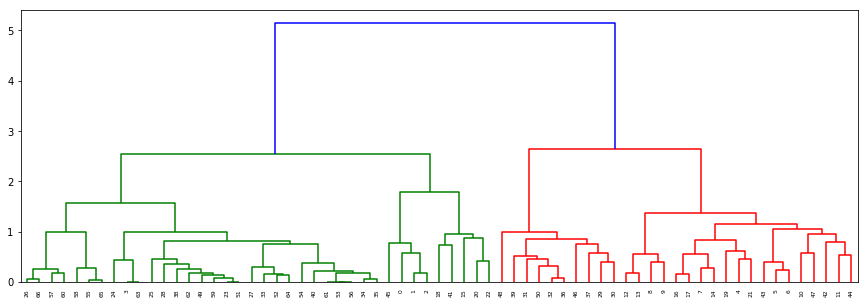

In [37]:
# hierachical clustering
n_sbt = 10
use_columns = pheno_clean_df.columns.drop('ID')
svec = RohG[np.triu_indices(len(RohG),1)]
dist = 1 - svec
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
plt.figure(figsize=(15, 5))
dn = scl.hierarchy.dendrogram(link)

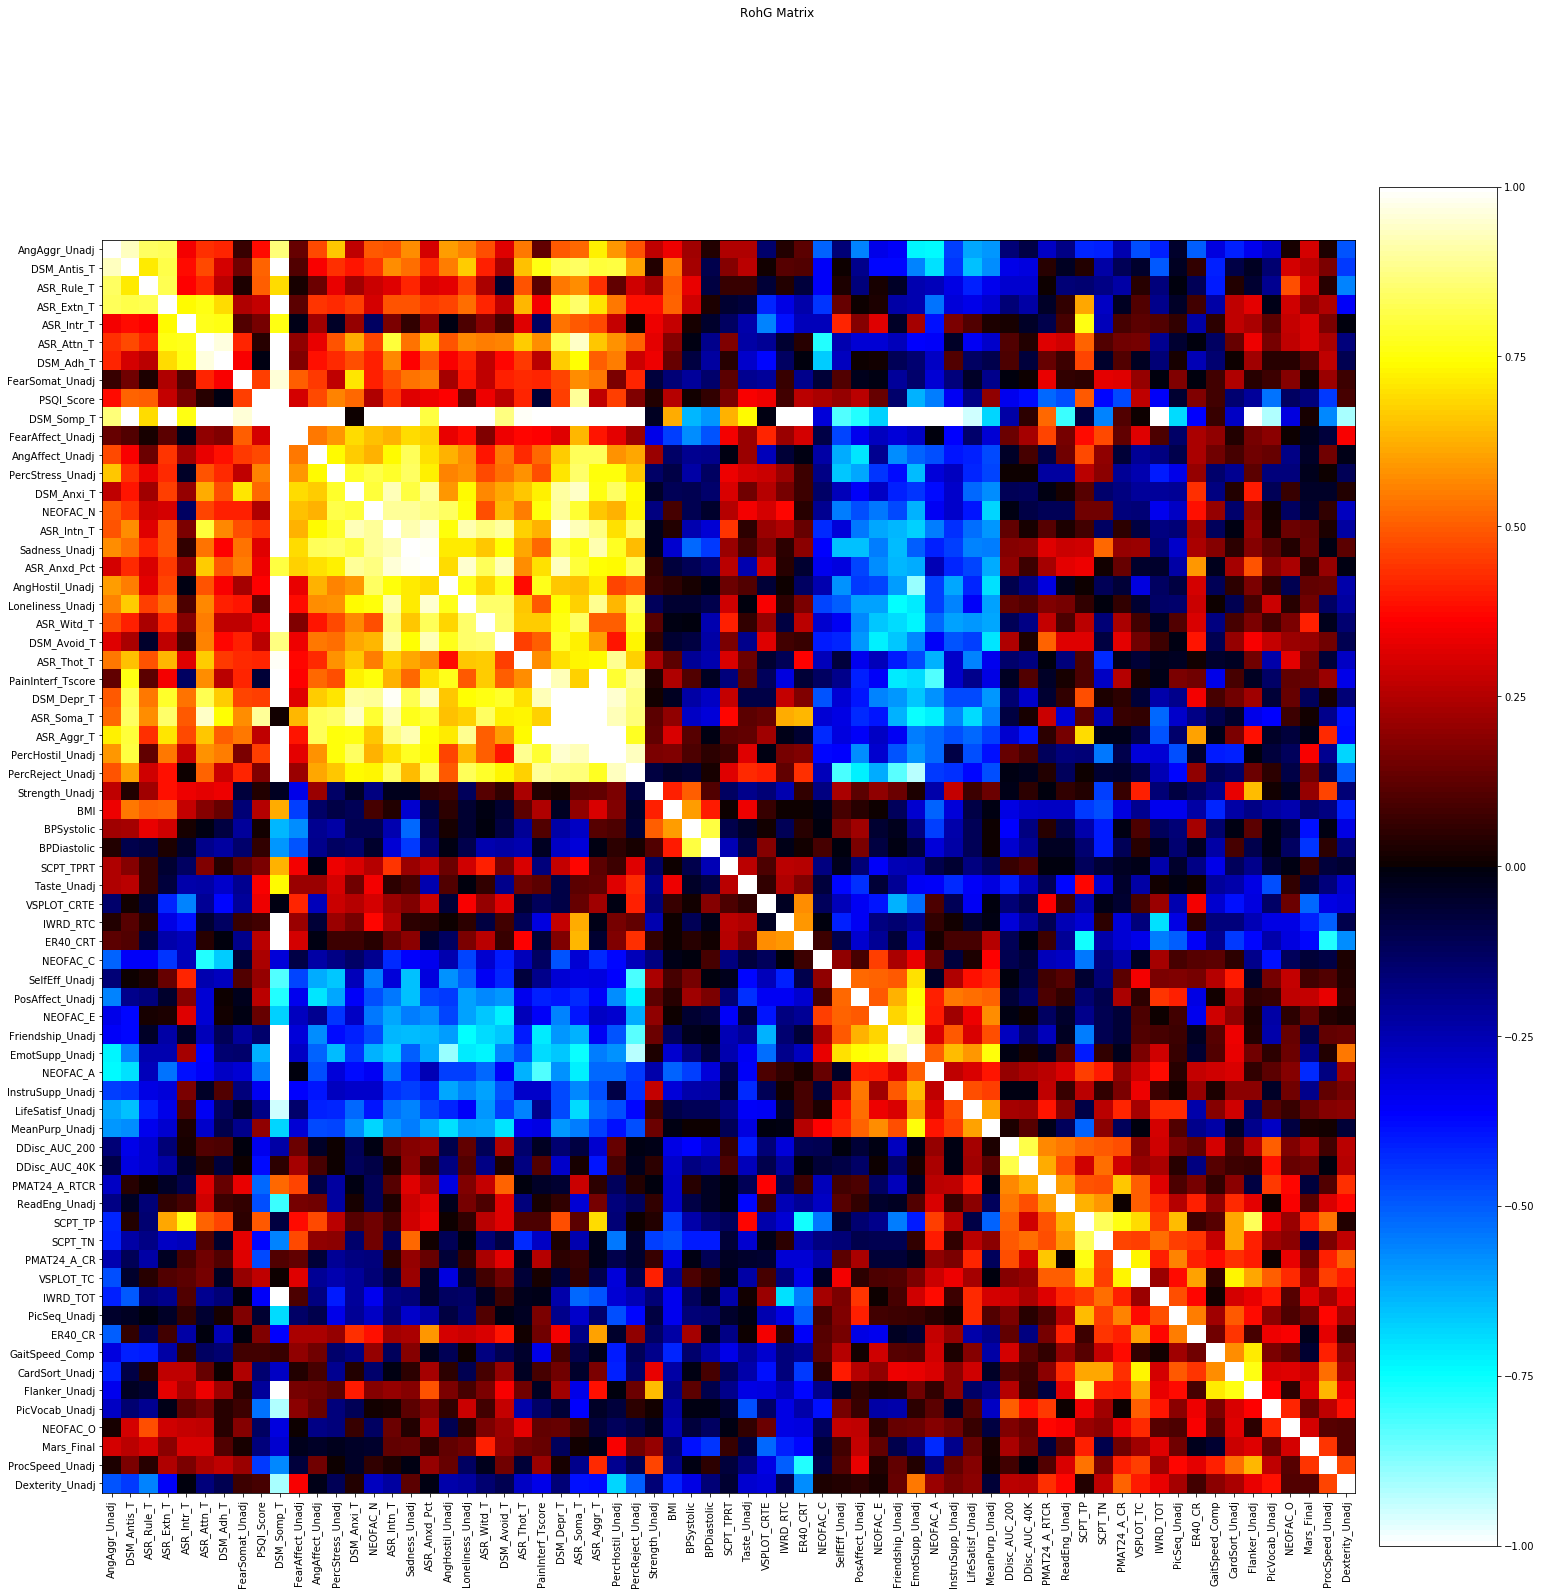

In [38]:
# Plot the RhoG matrix again, but now ordered by hierarchy
use_columns = pheno_clean_df.columns.drop('ID')
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(RohG[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RohG Matrix')

### Calculate silhouette

In [39]:
%load_ext oct2py.ipython
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [40]:
%%octave -o sil,hier,ind_s,val_s -i RohG,n_sbt

hier = niak_hierarchical_clustering(RohG,struct('flag_verbose',false)); # replication the hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',30)); # Cut the hierarchy to get clusters
sil = niak_build_avg_silhouette (RohG,hier);
[val_s,ind_s] = niak_find_local_max_1d(2:30,sil(1:29))

     Percentage done : 0 6 11 15 21 26 30 36 41 45 50 56 61 65 71 76 80 86 91 95 Done ! 

val_s =  0.44266

ind_s =  2

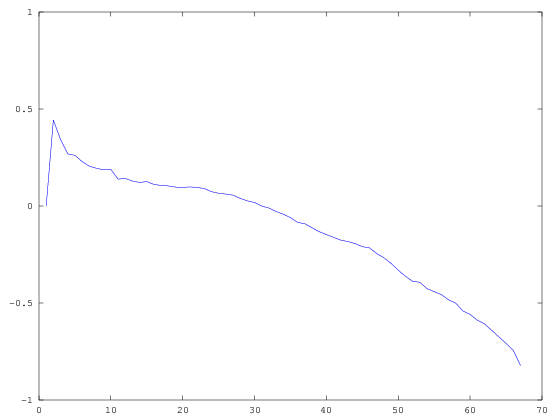

In [41]:
%octave plot(sil)

### Plot silouhette

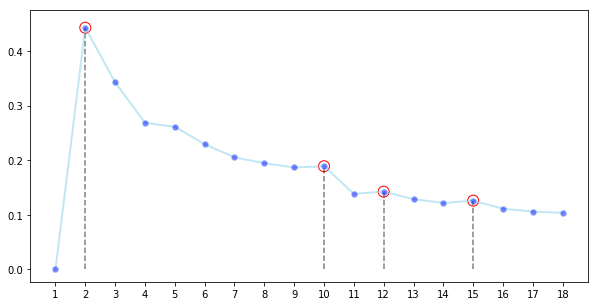

In [42]:
# plot silhouette figure
from scipy.signal import find_peaks
# trunck it first
sil_trunc = [ss[0] for ss in sil][:18]
plt.figure(figsize=(10,5))

# plot silhouette
plt.plot(np.arange(1,len(sil_trunc)+1),sil_trunc, marker='o',
         markerfacecolor='blue',alpha = 0.5,
         markersize=6, color='skyblue', linewidth=2)

# Find peaks
peaks, _ = find_peaks(sil_trunc, height=0)

# plot peaks on top of silhouette
plt.scatter(peaks+1,[sil_trunc[x]  for x in peaks], s=120, facecolors='none', edgecolors='r')
plt.vlines(peaks+1,0,[sil_trunc[x]  for x in peaks],linestyle='--',alpha = 0.5)
plt.xticks(np.arange(1,len(sil_trunc)+1, step=1));
plt.savefig(os.path.join(path_root,'Figures/behavioral/silhouette_RhoG.svg'))

In [43]:
# Order clustered correlation matrix according to meta-subtypes order
# load meta subtype order
#path_pleio = os.path.join(path_root,'pleio_2018-07-26')

RohG = np.load(os.path.join(path_pleio, 'RhoG.npy'))
RohG_pval_0 = np.load(os.path.join(path_pleio, 'RhoG_pval_0.npy'))
# Order clustered correlation matrix
RohG_clust = RohG[order, :][:, order]
RohG_p0_fd_clust = RohG_p0_fd[order, :][:, order]
RohG_p1_fd_clust = RohG_p1_fd[order, :][:, order]
RohG_pm1_fd_clust = RohG_pm1_fd[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

# Generate boxes
mat, cmat, lmat, ind = make_boxes(RohG_clust, cuts, 1)

# Order clustered correlation matrix
RohG_clust = RohG[order, :][:, order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

In [44]:
# Generate boxes
mat, cmat, lmat, ind = make_boxes(RohG_clust, cuts, 1)
mat_fd0, cmat_fd0, lmat_fd0, ind_fd0 = make_boxes(RohG_p0_fd_clust, cuts, 1)
mat_fd1, cmat_fd1, lmat_fd1, ind_fd1 = make_boxes(RohG_p1_fd_clust, cuts, 1)
mat_fdm1, cmat_fdm1, lmat_fdm1, ind_fdm1 = make_boxes(RohG_pm1_fd_clust, cuts, 1)

In [45]:
# Order clustered correlation matrix
RohG_clust = RohG[order, :][:, order]
pco = part[order]
# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

#### RhoG 

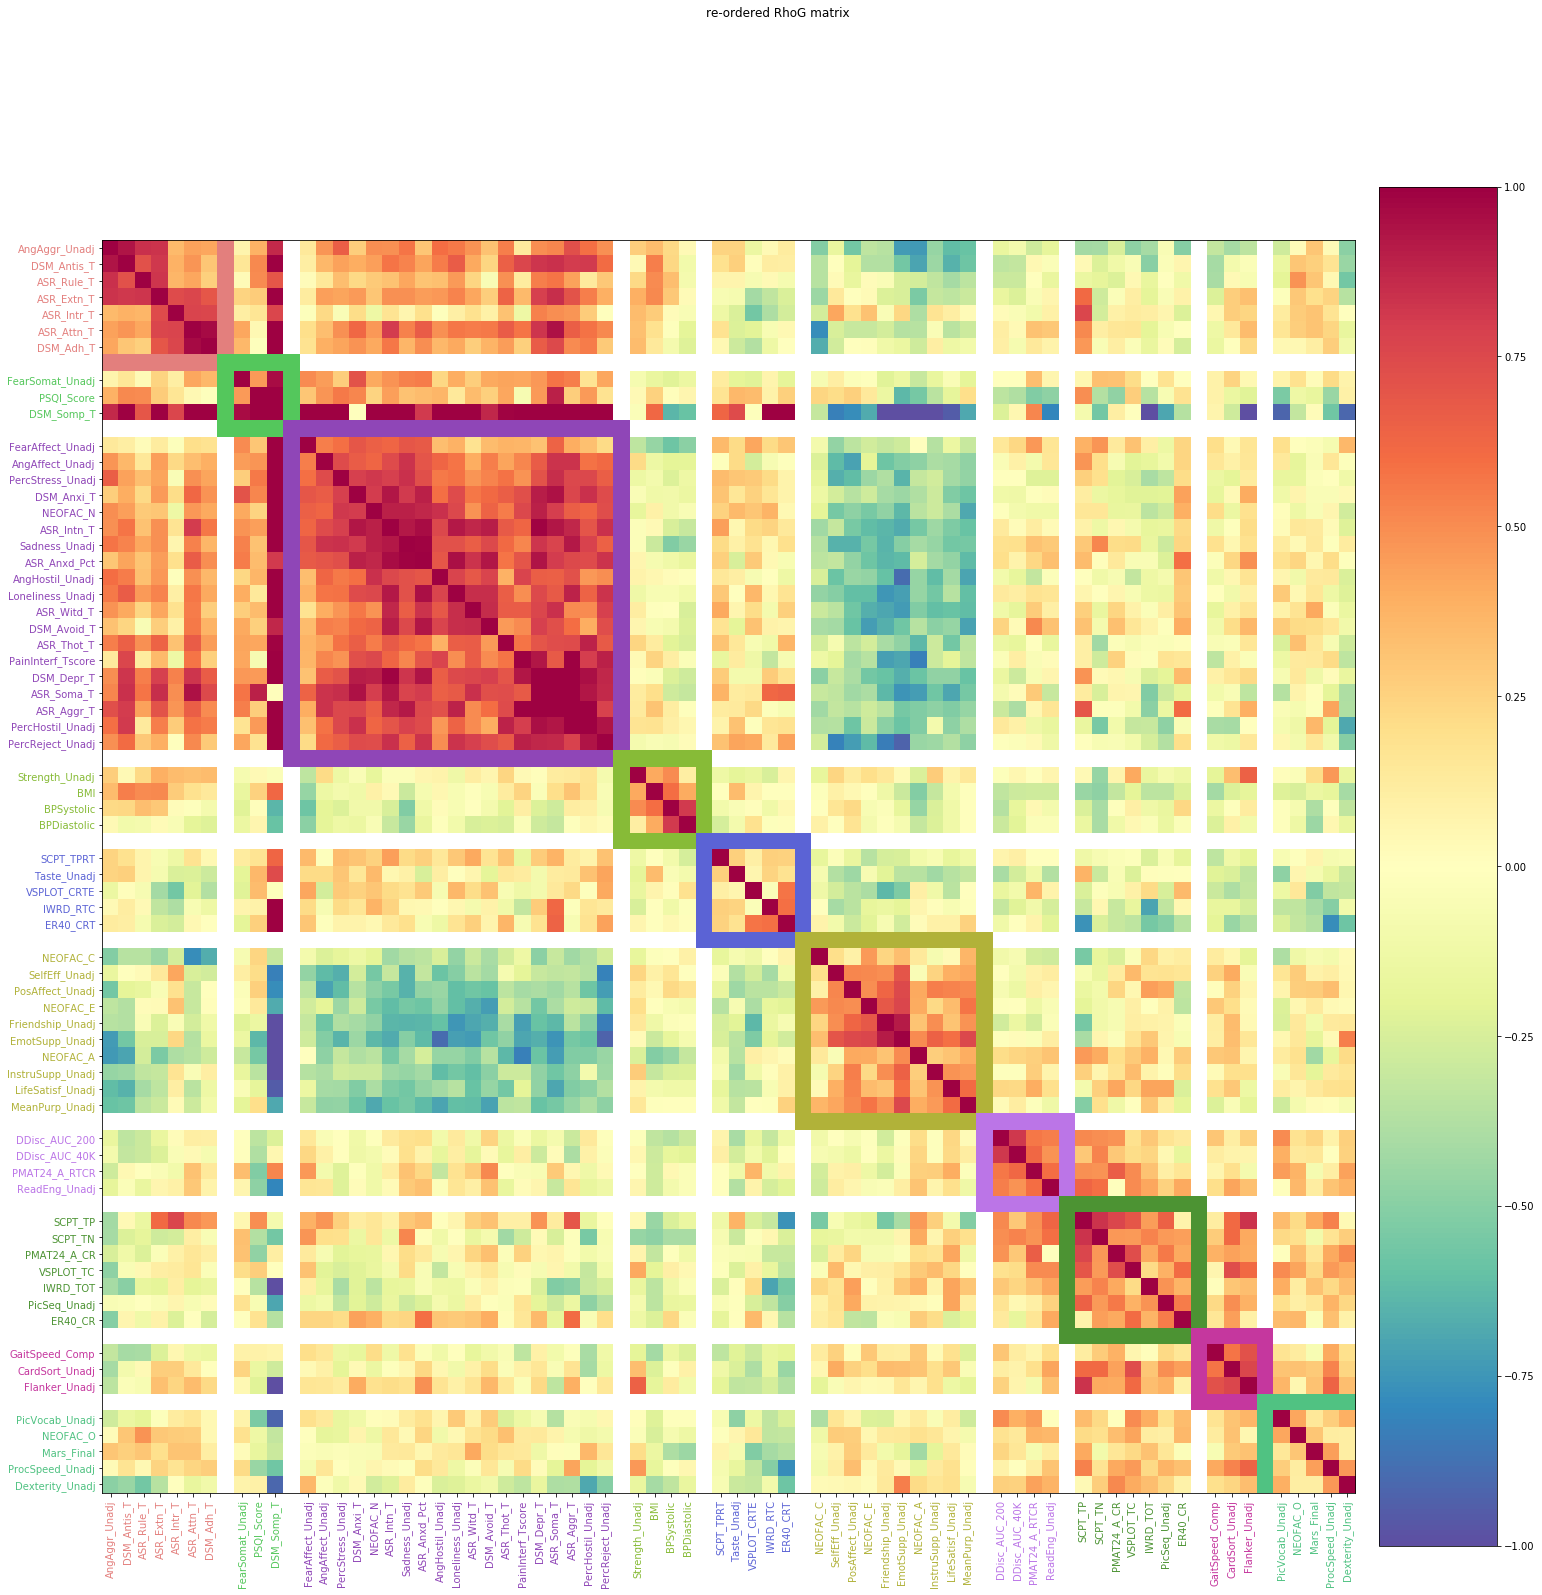

In [46]:
# Set figure
lin,color_list = clusters_color(n_sbt)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat, cmap=plt.cm.Spectral_r,interpolation='none', vmin=-1, vmax=1)
tmp = ax.imshow(lmat, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat, cmap=lin,interpolation='none')
tmp = ax.set_yticks(ind)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [color_list[i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered RhoG matrix')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

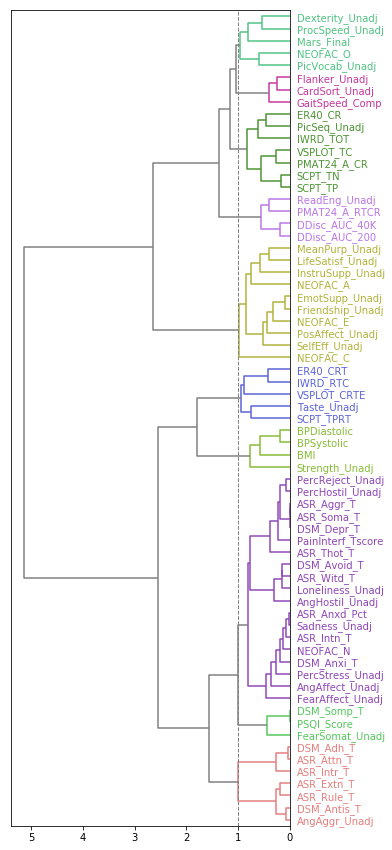

In [62]:
# plot dendrograme figure
fig = plt.figure(figsize=(5, 15))
link = scl.hierarchy.linkage(dist, method='ward')

#set color from color list
scl.hierarchy.set_link_color_palette(color_list)

# plot dendro
dn = scl.hierarchy.dendrogram(link,labels=pheno_clean_df.columns.drop('ID'),
                              leaf_rotation=0,
                              orientation="left",
                              color_threshold=.995,
                              above_threshold_color='grey',
                              leaf_font_size = '10')
plt.axvline(x=.995, c='grey', lw=1, linestyle='dashed')

# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=colors[num]
    lbl.set_color(val)
fig.savefig(os.path.join(path_root,'Figures/behavioral/dendrogram_cluster_RhoG_1200.svg'))

#### RhoG pval 0

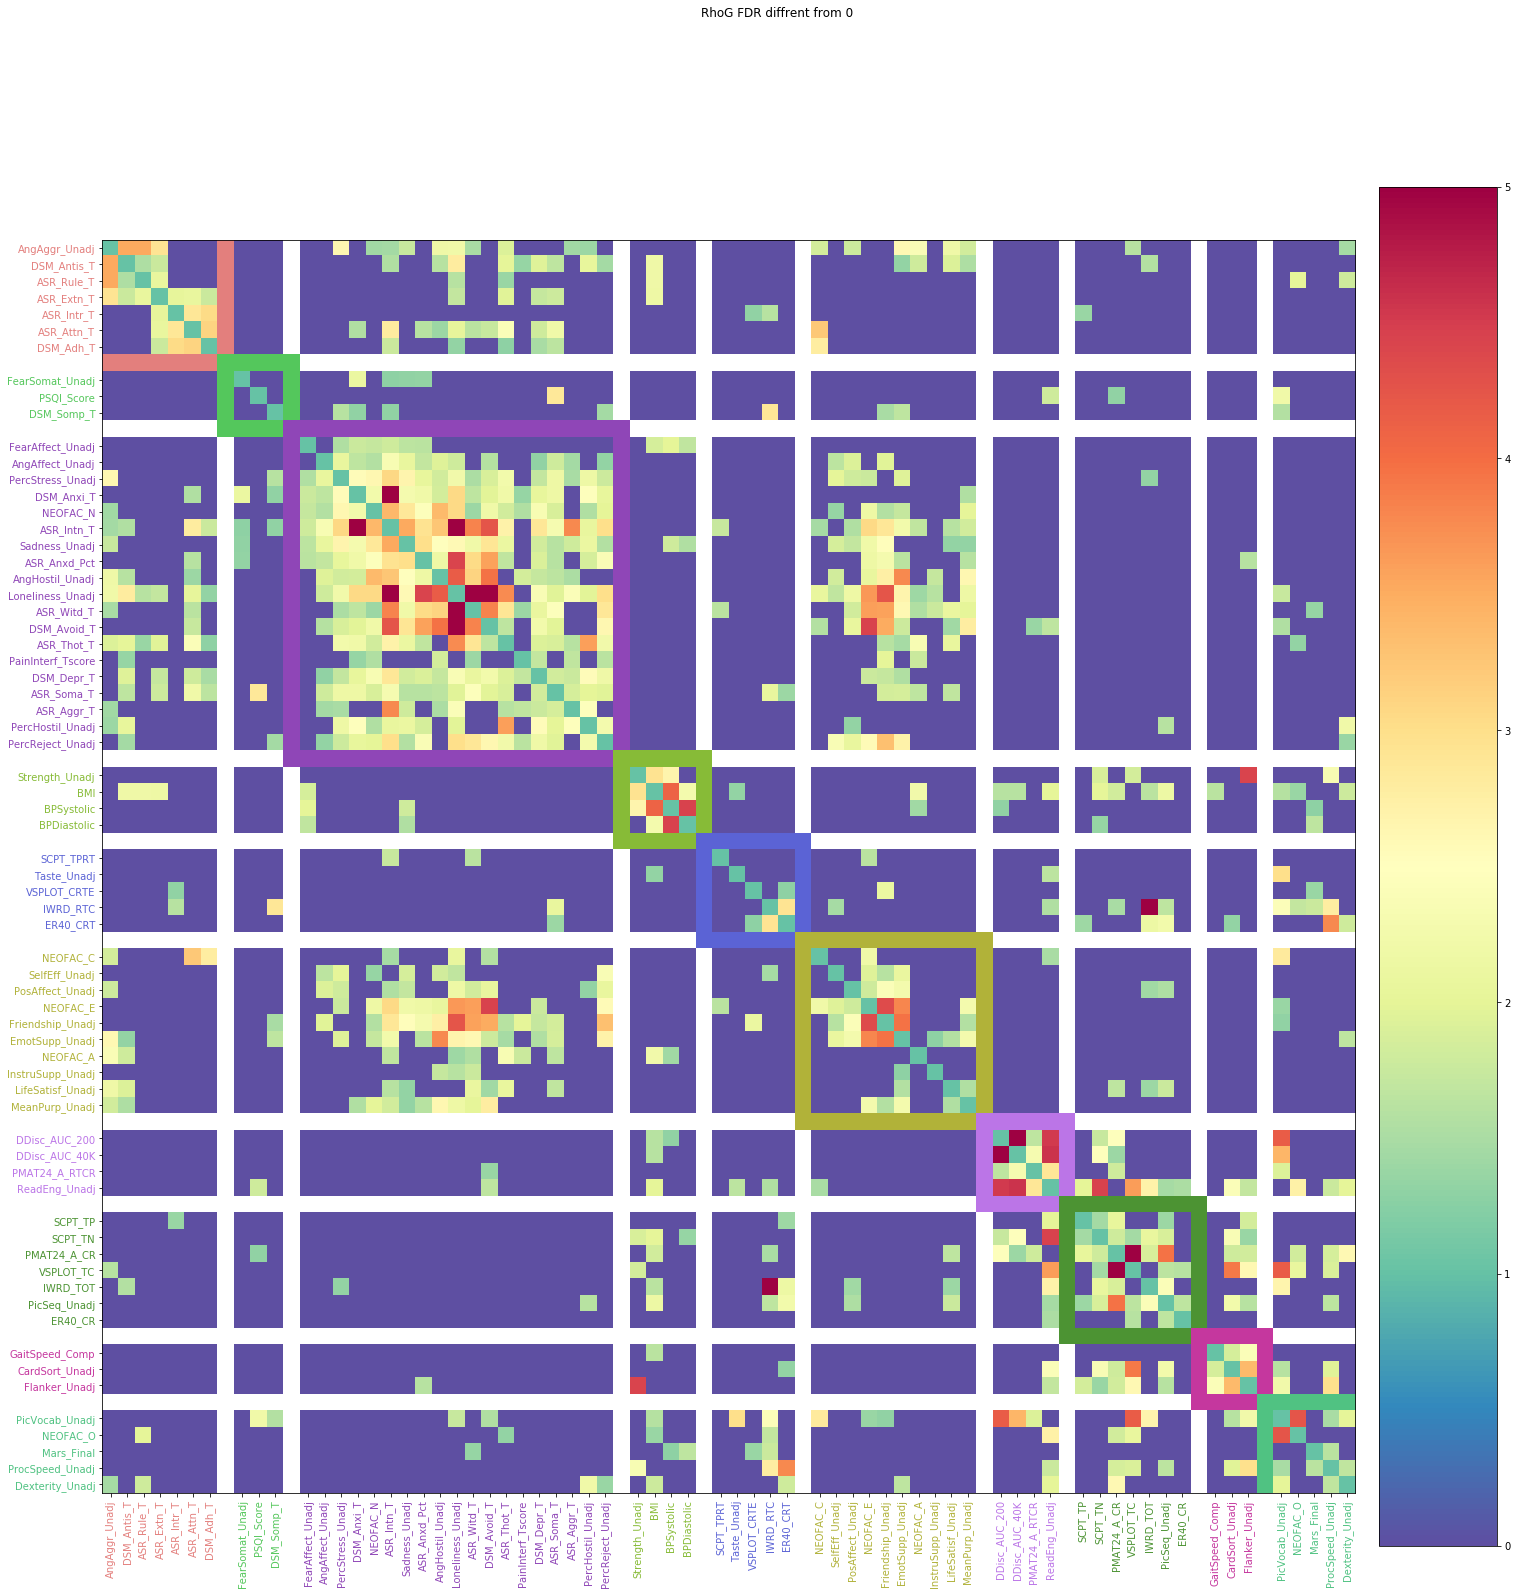

In [63]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat_fd0, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=5)
tmp = ax.imshow(lmat_fd0, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat_fd0, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat_fd0, cmap=lin,interpolation='none')
tmp = ax.set_yticks(ind_fd0)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind_fd0)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [color_list[i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoG FDR diffrent from 0')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

#### RhoG pval 1

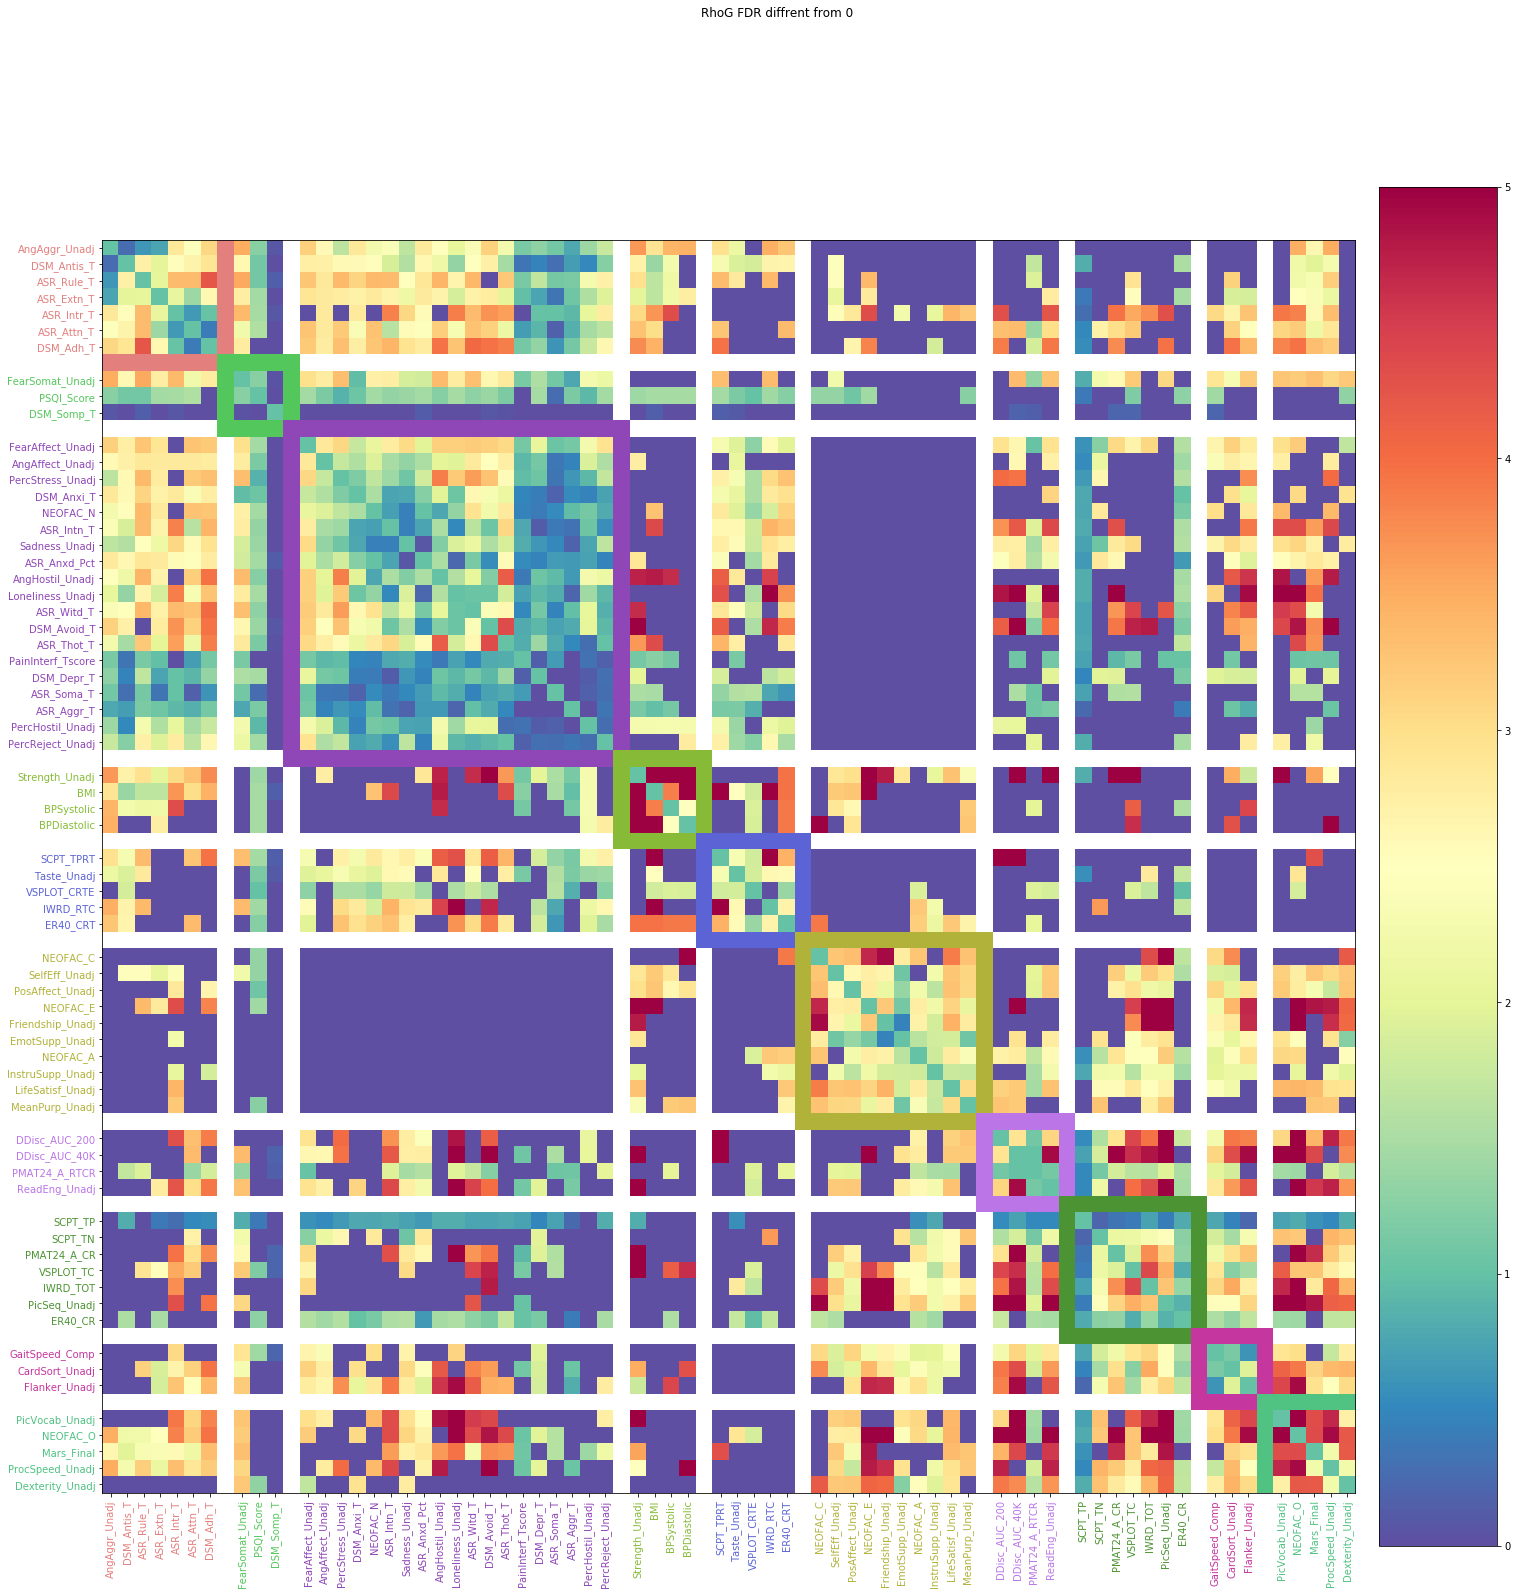

In [64]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat_fd1, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=5)
tmp = ax.imshow(lmat_fd1, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat_fd1, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat_fd1, cmap=lin,interpolation='none')
tmp = ax.set_yticks(ind_fd1)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind_fd1)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [color_list[i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoG FDR diffrent from 0')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

#### RhoG pval minus 1

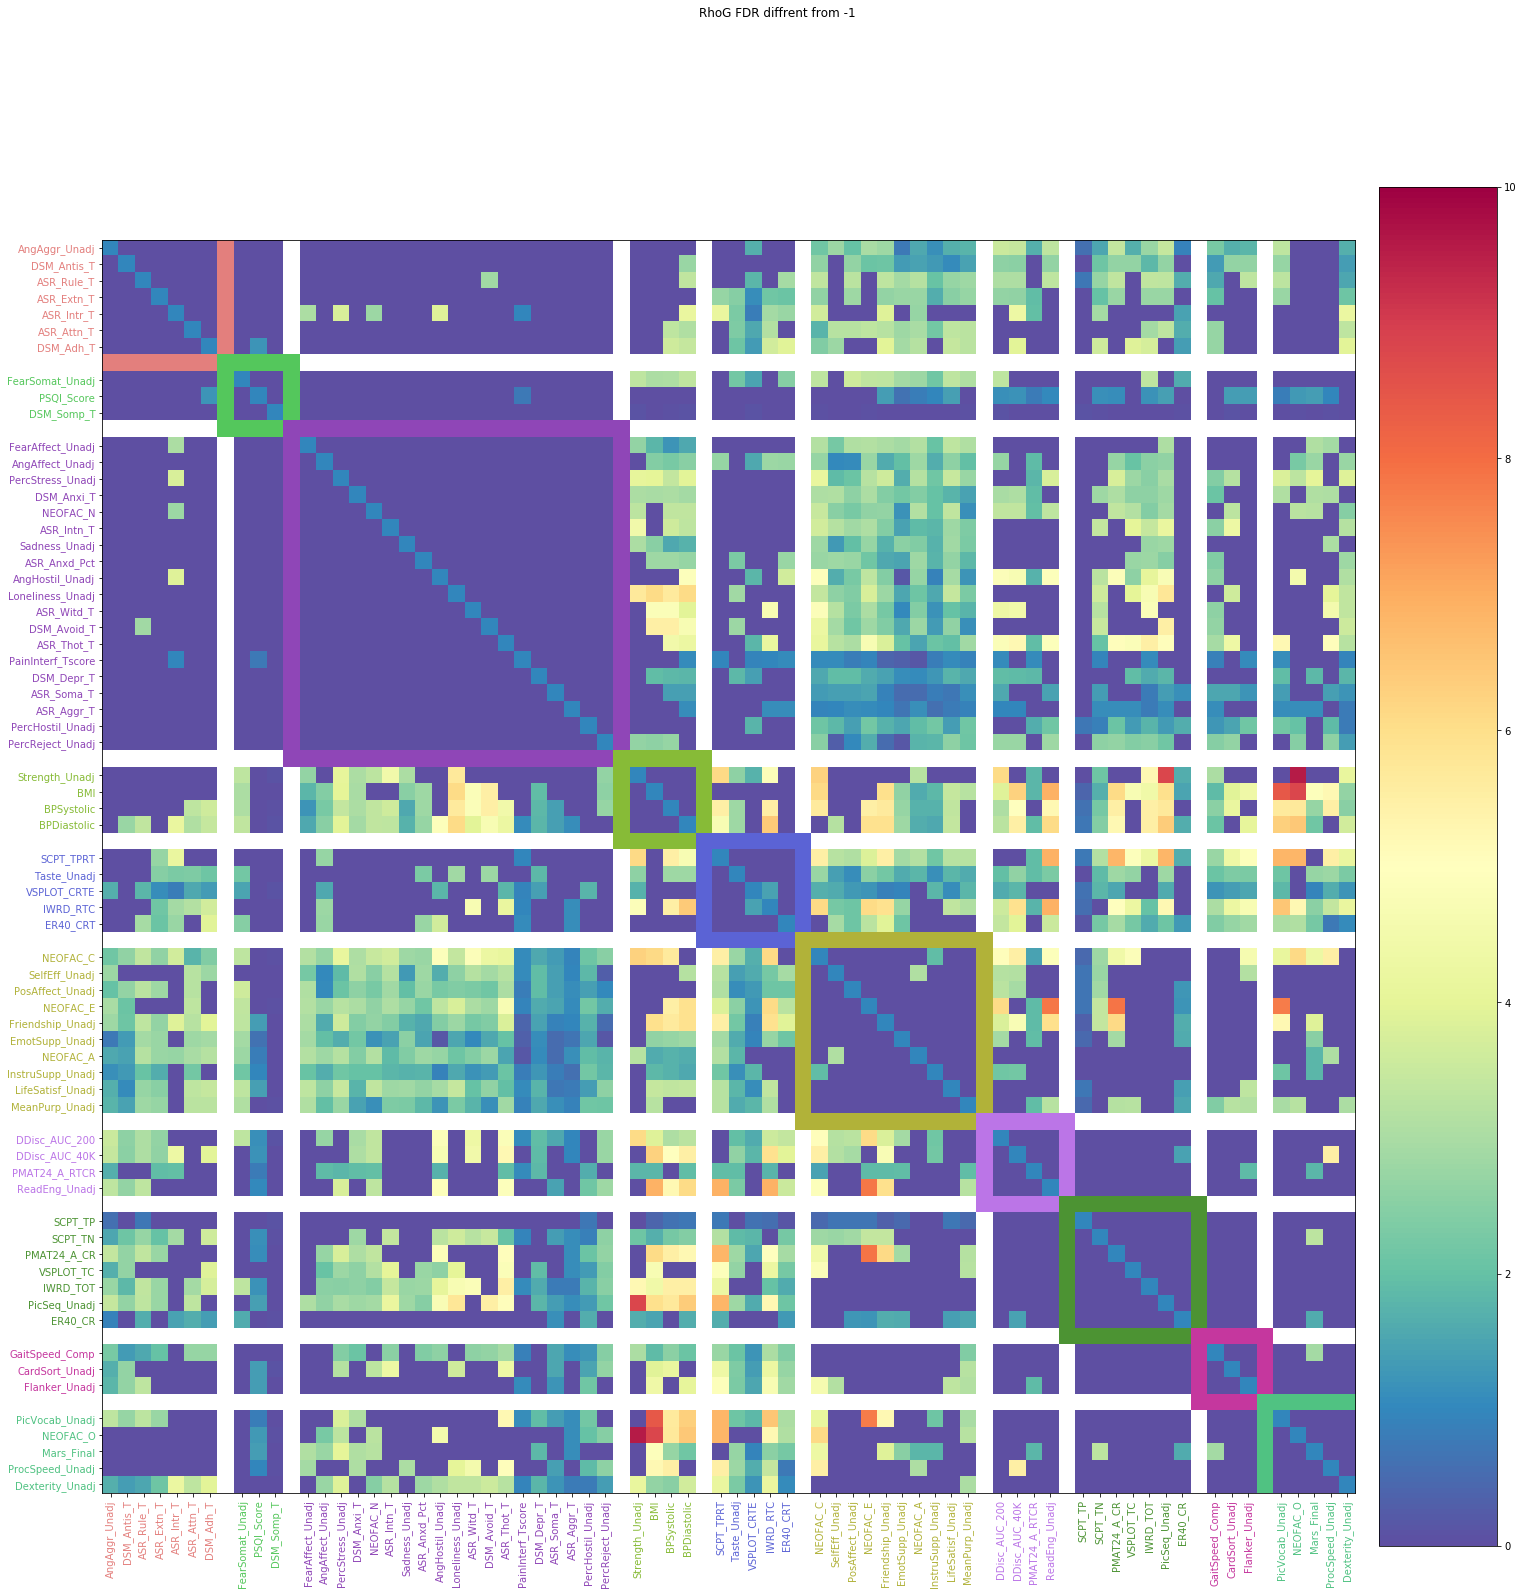

In [65]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat_fdm1, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=10)
tmp = ax.imshow(lmat_fdm1, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat_fdm1, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat_fdm1, cmap=lin,interpolation='none')
tmp = ax.set_yticks(ind_fdm1)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind_fdm1)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [color_list[i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoG FDR diffrent from -1')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

### Cluster RhoE matrice

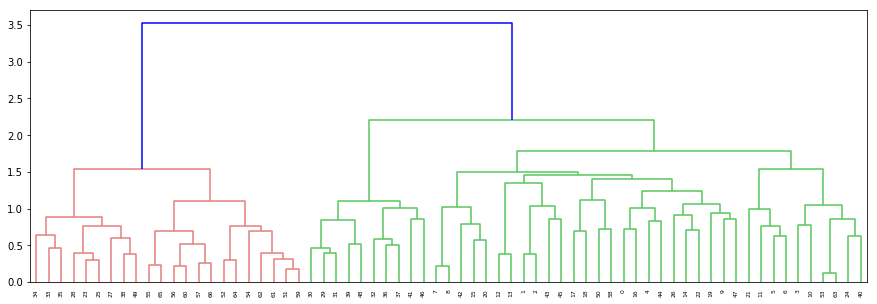

In [72]:
# hierachical clustering
n_sbt = 9
svec = RohE[np.triu_indices(len(RohE),1)]
dist = 1 - svec
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
plt.figure(figsize=(15, 5))
dn = scl.hierarchy.dendrogram(link)

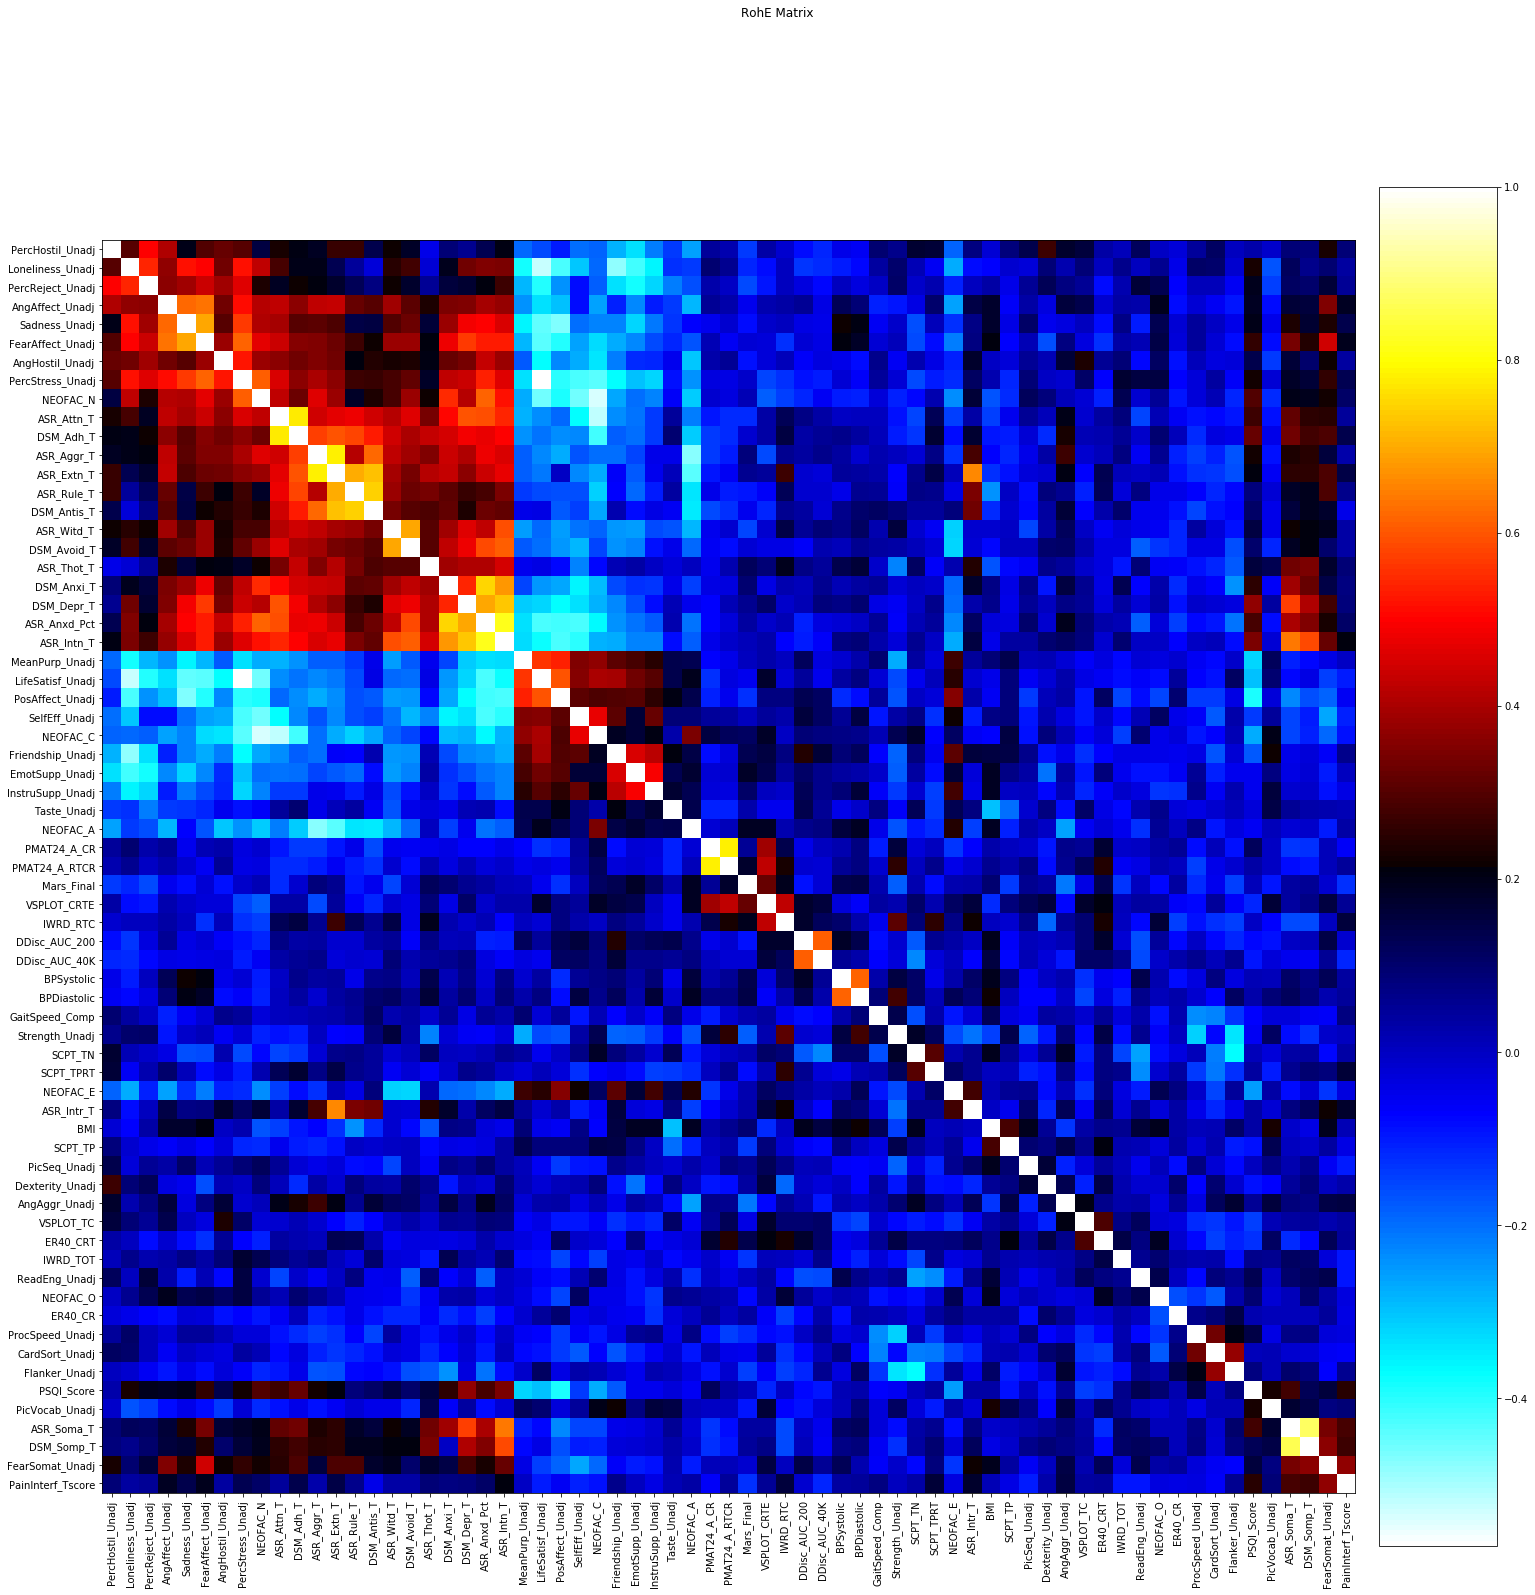

In [73]:
# Plot the RhoE matrix again, but now ordered by hierarchy
use_columns = pheno_clean_df.columns.drop('ID')
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(RohE[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RohE Matrix')

In [74]:
%%octave -o sil,hier,ind_s,val_s -i RohE,n_sbt

hier = niak_hierarchical_clustering(RohE,struct('flag_verbose',false)); # replication the hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',n_sbt)); # Cut the hierarchy to get clusters
sil = niak_build_avg_silhouette (RohE,hier);
[val_s,ind_s] = niak_find_local_max_1d(2:30,sil(1:29))

     Percentage done : 0 6 11 15 21 26 30 36 41 45 50 56 61 65 71 76 80 86 91 95 Done ! 

val_s =

   0.17225

   0.12287

   0.14029

ind_s =

    2

    9

   22

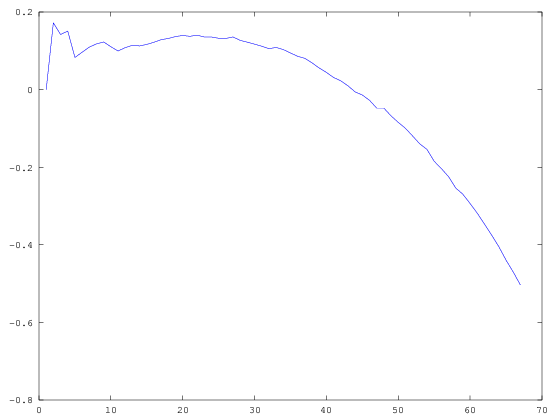

In [75]:
%octave plot(sil)

### Plot silouhette

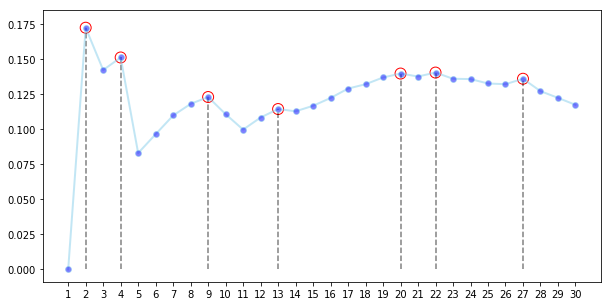

In [76]:
# plot silhouette figure
from scipy.signal import find_peaks
# trunck it first
sil_trunc = [ss[0] for ss in sil][:30]
plt.figure(figsize=(10,5))

# plot silhouette
plt.plot(np.arange(1,len(sil_trunc)+1),sil_trunc, marker='o',
         markerfacecolor='blue',alpha = 0.5,
         markersize=6, color='skyblue', linewidth=2)

# Find peaks
peaks, _ = find_peaks(sil_trunc, height=0)

# plot peaks on top of silhouette
plt.scatter(peaks+1,[sil_trunc[x]  for x in peaks], s=120, facecolors='none', edgecolors='r')
plt.vlines(peaks+1,0,[sil_trunc[x]  for x in peaks],linestyle='--',alpha = 0.5)
plt.xticks(np.arange(1,len(sil_trunc)+1, step=1));
plt.savefig(os.path.join(path_root,'Figures/behavioral/silhouette_RhoE_1200.svg'))

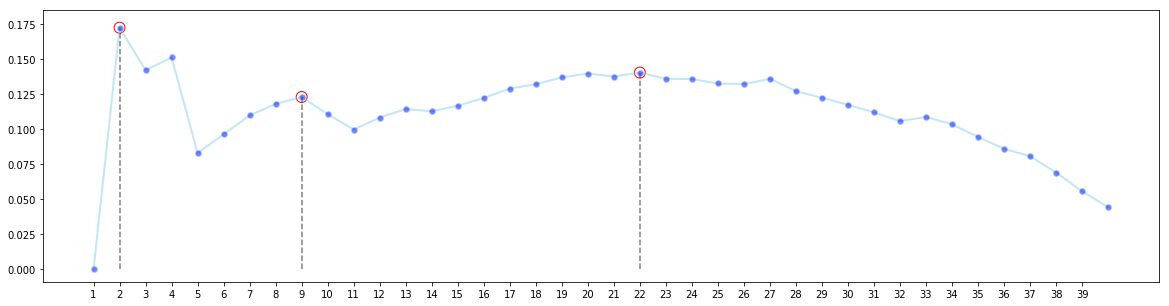

In [77]:
# plot silhouette figure
sil_trunc = sil[:40]
plt.figure(figsize=(20,5))
plt.plot(np.arange(1,len(sil_trunc)+1),sil_trunc, marker='o',
         markerfacecolor='blue',alpha = 0.5,
         markersize=6, color='skyblue', linewidth=2)
if isinstance(ind_s,np.ndarray):
    for ind, val in zip(ind_s,val_s):
        plt.scatter(int(ind),float(val), s=120, facecolors='none', edgecolors='r')
        plt.vlines(int(ind),0,float(val),linestyle='--',alpha = 0.5)
else:
    plt.scatter(int(ind_s),float(val_s), s=120, facecolors='none', edgecolors='r')
    plt.vlines(int(ind_s),0,float(val_s),linestyle='--',alpha = 0.5)
    
plt.xticks(np.arange(1,len(sil_trunc), step=1));
#plt.savefig(os.path.join(path_root,'Figures/phenotypes/silhouette.svg'))

In [78]:
# Order clustered correlation matrix
RohE_clust = RohE[order, :][:, order]
RohE_p_fd_clust = RohE_p_fd[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

In [79]:
# Generate boxes
matE, cmatE, lmatE, indE = make_boxes(RohE_clust, cuts, 1)
matE_fd, cmatE_fd, lmatE_fd, indE_fd = make_boxes(RohE_p_fd_clust, cuts, 1)

#### RhoE 

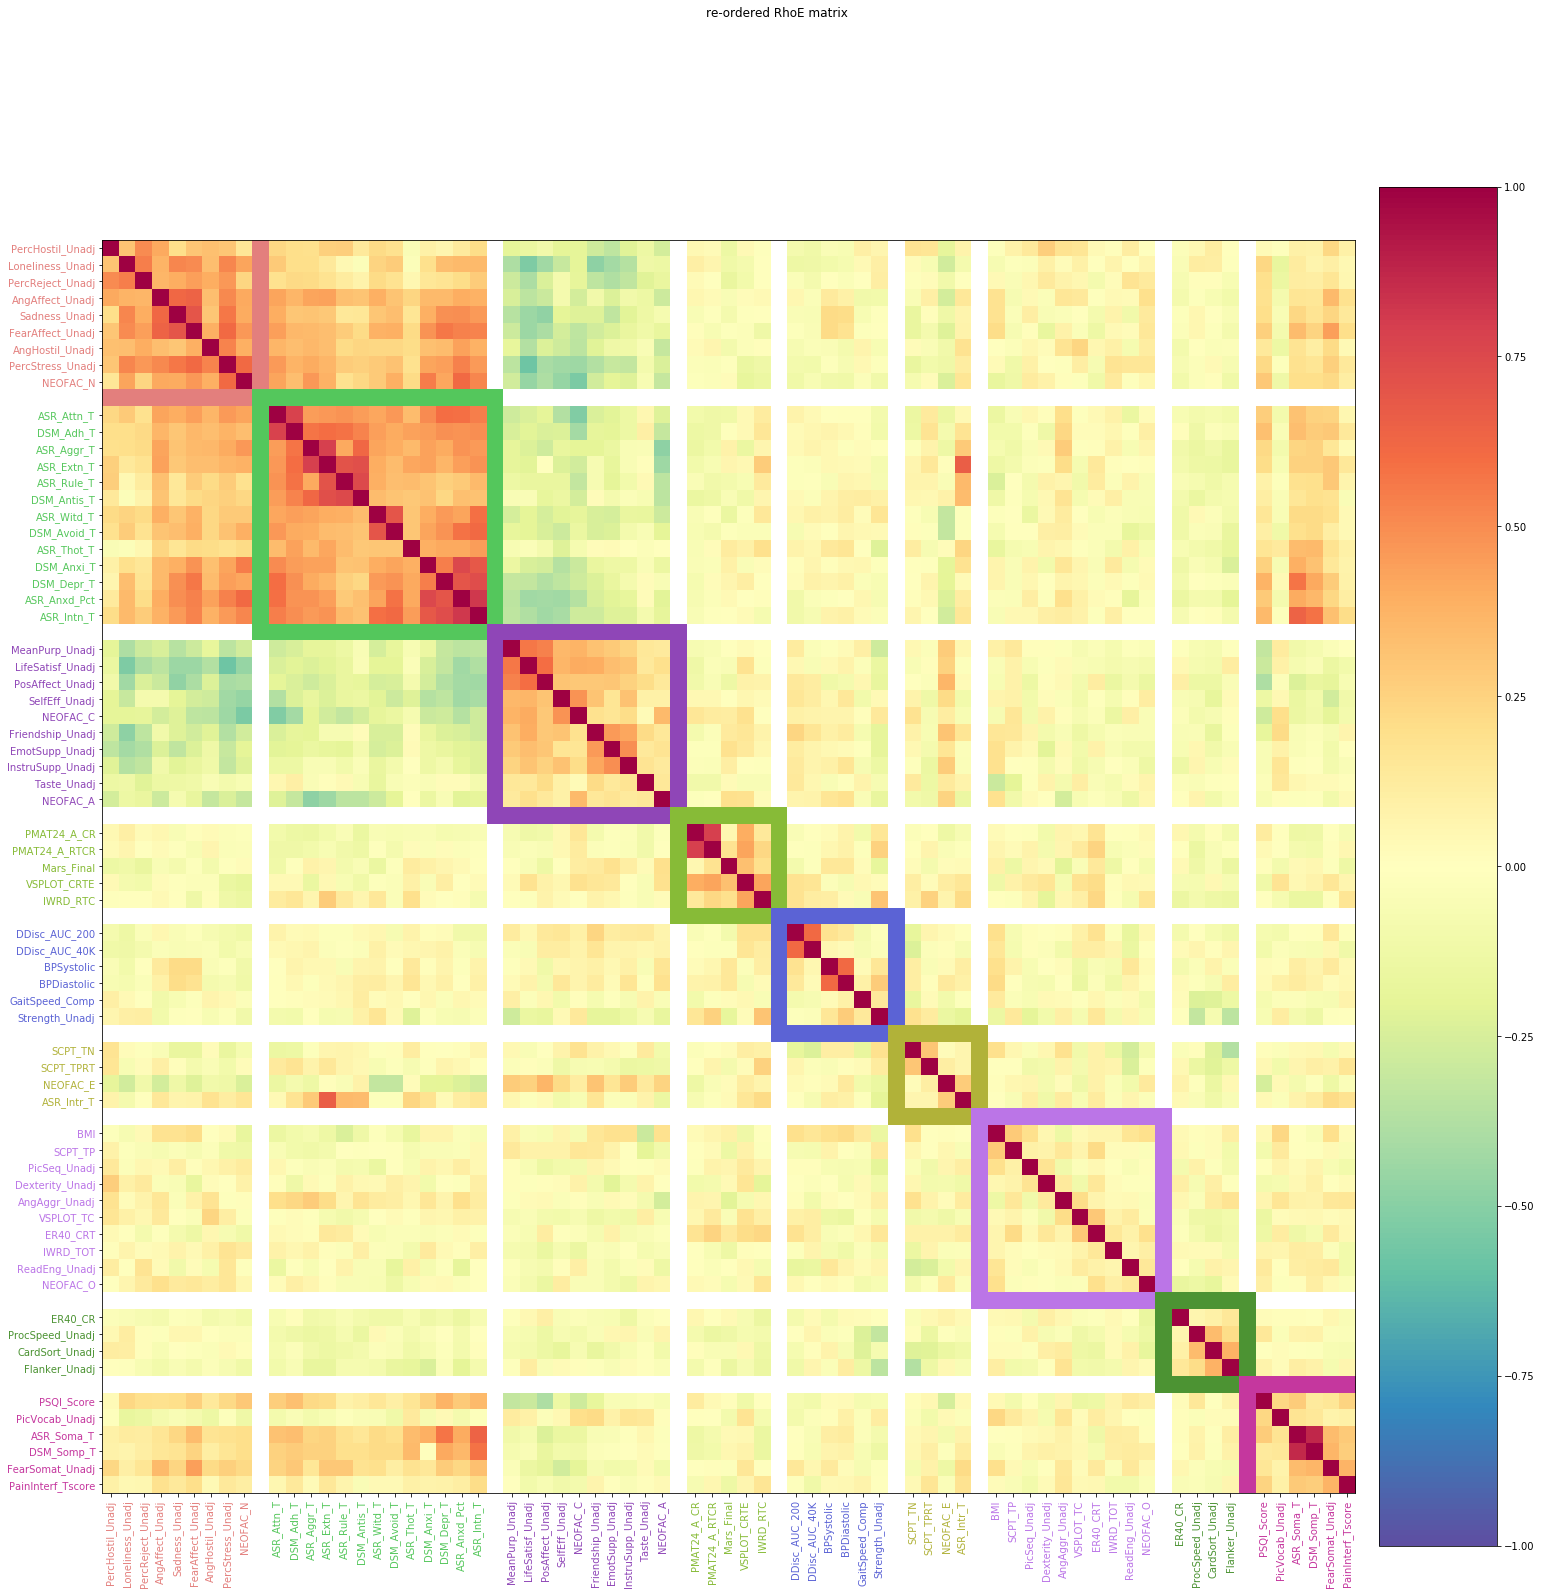

In [80]:
# Set figure
lin,color_list = clusters_color(n_sbt)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matE, cmap=plt.cm.Spectral_r,interpolation='none', vmin=-1, vmax=1)
tmp = ax.imshow(lmatE, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmatE, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmatE, cmap=lin,interpolation='none')
tmp = ax.set_yticks(indE)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indE)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [color_list[i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered RhoE matrix')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

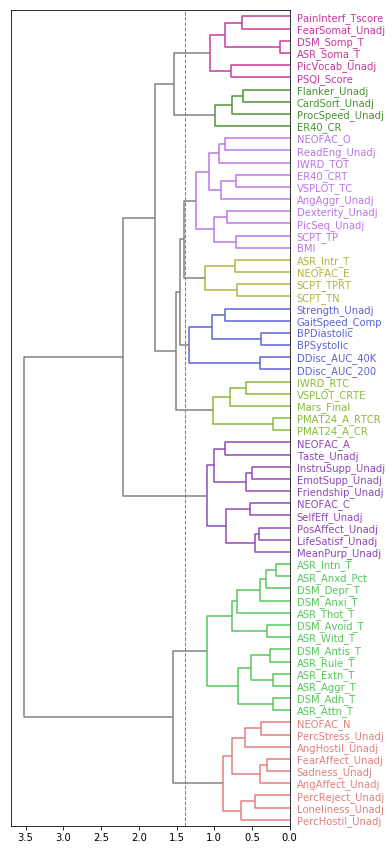

In [81]:
# plot dendrograme figure
fig = plt.figure(figsize=(5, 15))
link = scl.hierarchy.linkage(dist, method='ward')

#set color from color list
scl.hierarchy.set_link_color_palette(color_list)

# plot dendro
dn = scl.hierarchy.dendrogram(link,labels=pheno_clean_df.columns.drop('ID'),
                              leaf_rotation=0,
                              orientation="left",
                              color_threshold=1.39,
                              above_threshold_color='grey',
                              leaf_font_size = '10')
plt.axvline(x=1.39, c='grey', lw=1, linestyle='dashed')

# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=colors[num]
    lbl.set_color(val)
fig.savefig(os.path.join(path_root,'Figures/behavioral/dendrogram_cluster_RhoE_1200.svg'))

#### RhoE pval

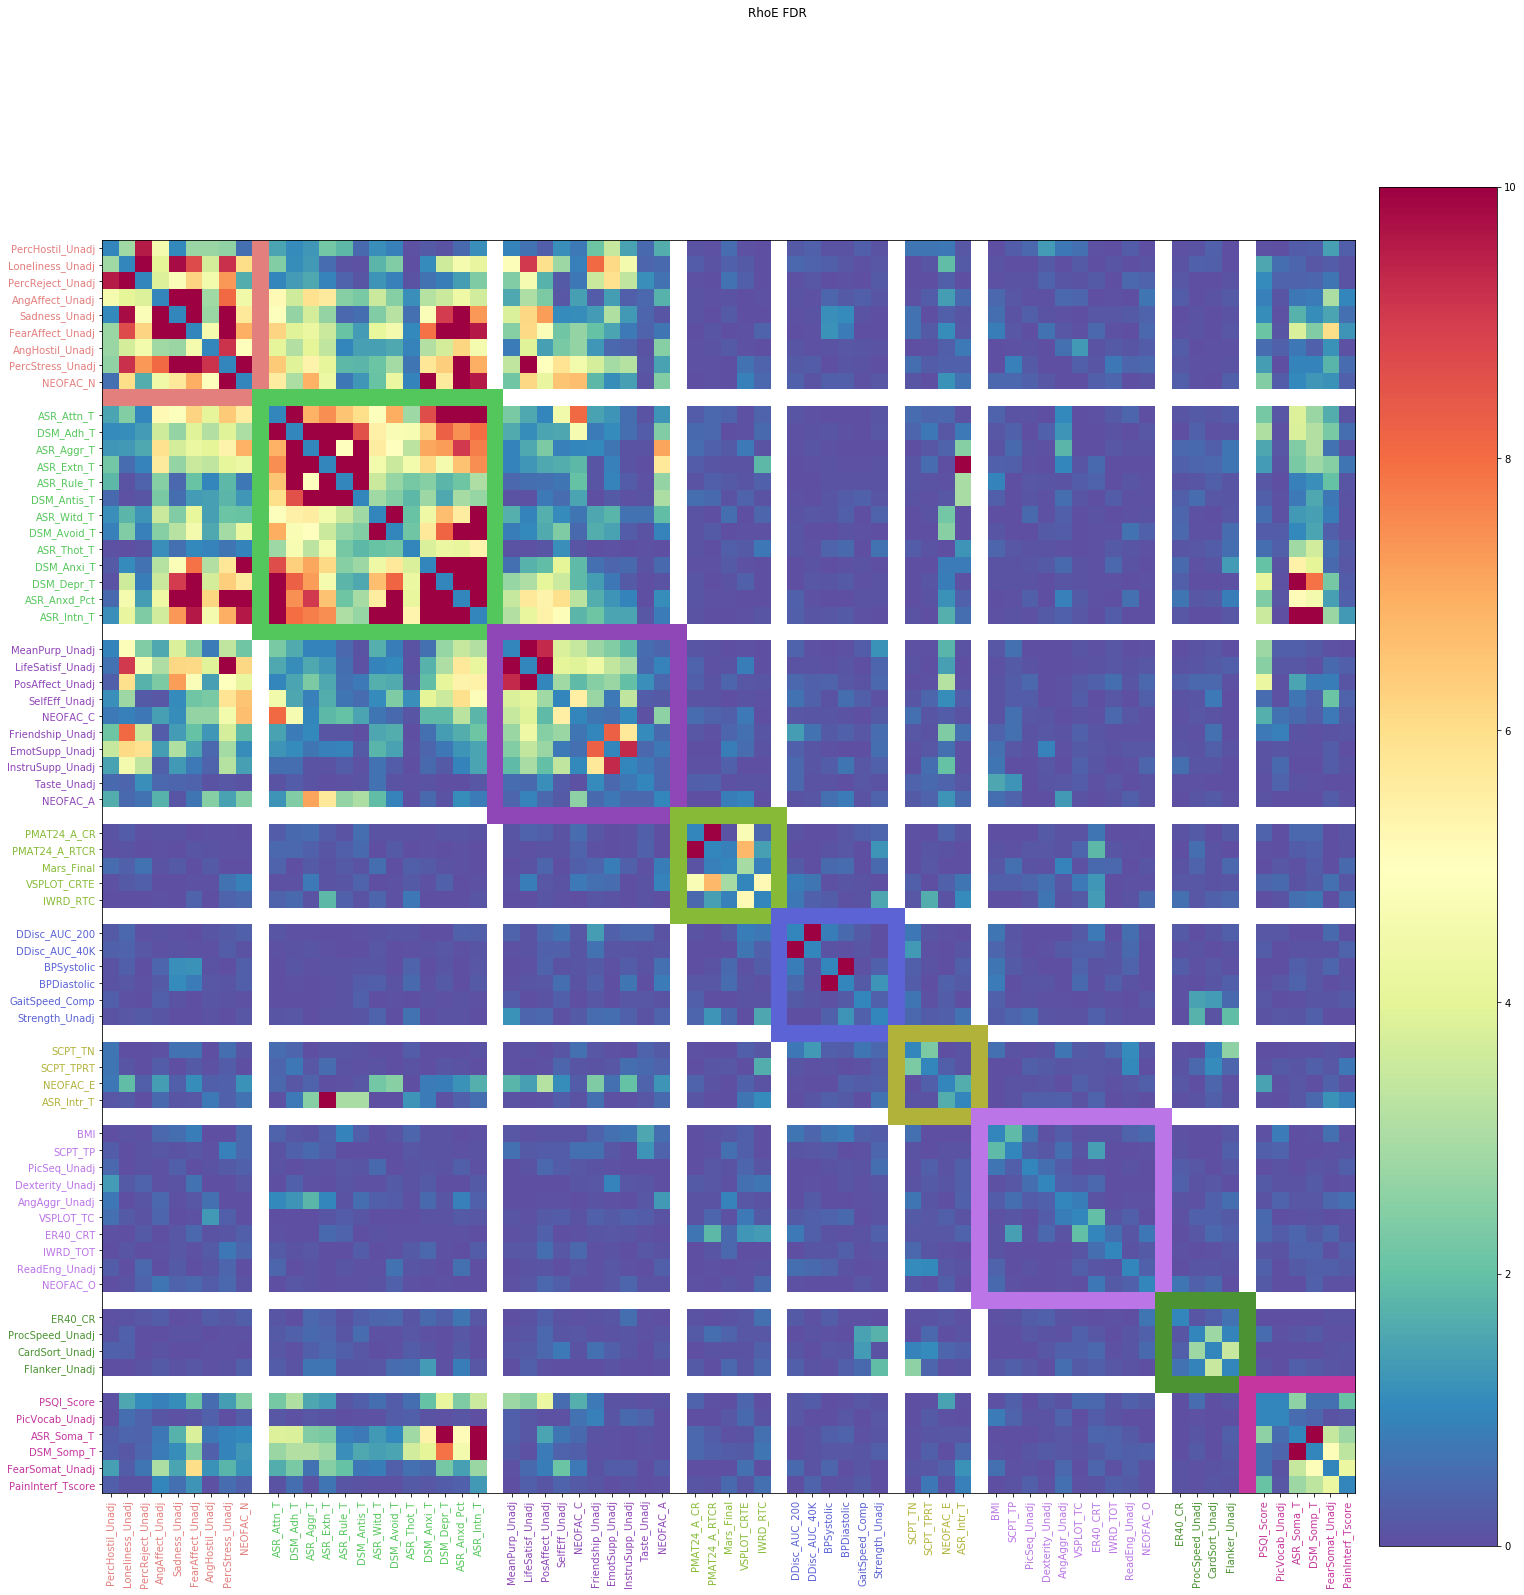

In [82]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matE_fd, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=10)
tmp = ax.imshow(lmatE_fd, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmatE_fd, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmatE_fd, cmap=lin,interpolation='none')
tmp = ax.set_yticks(indE_fd)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indE_fd)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [color_list[i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoE FDR')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

### Cluster RhoP matrice

In [83]:
# hierachical clustering
n_sbt = 13
svec = RohP[np.triu_indices(len(RohP),1)]
dist = 1 - svec
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']


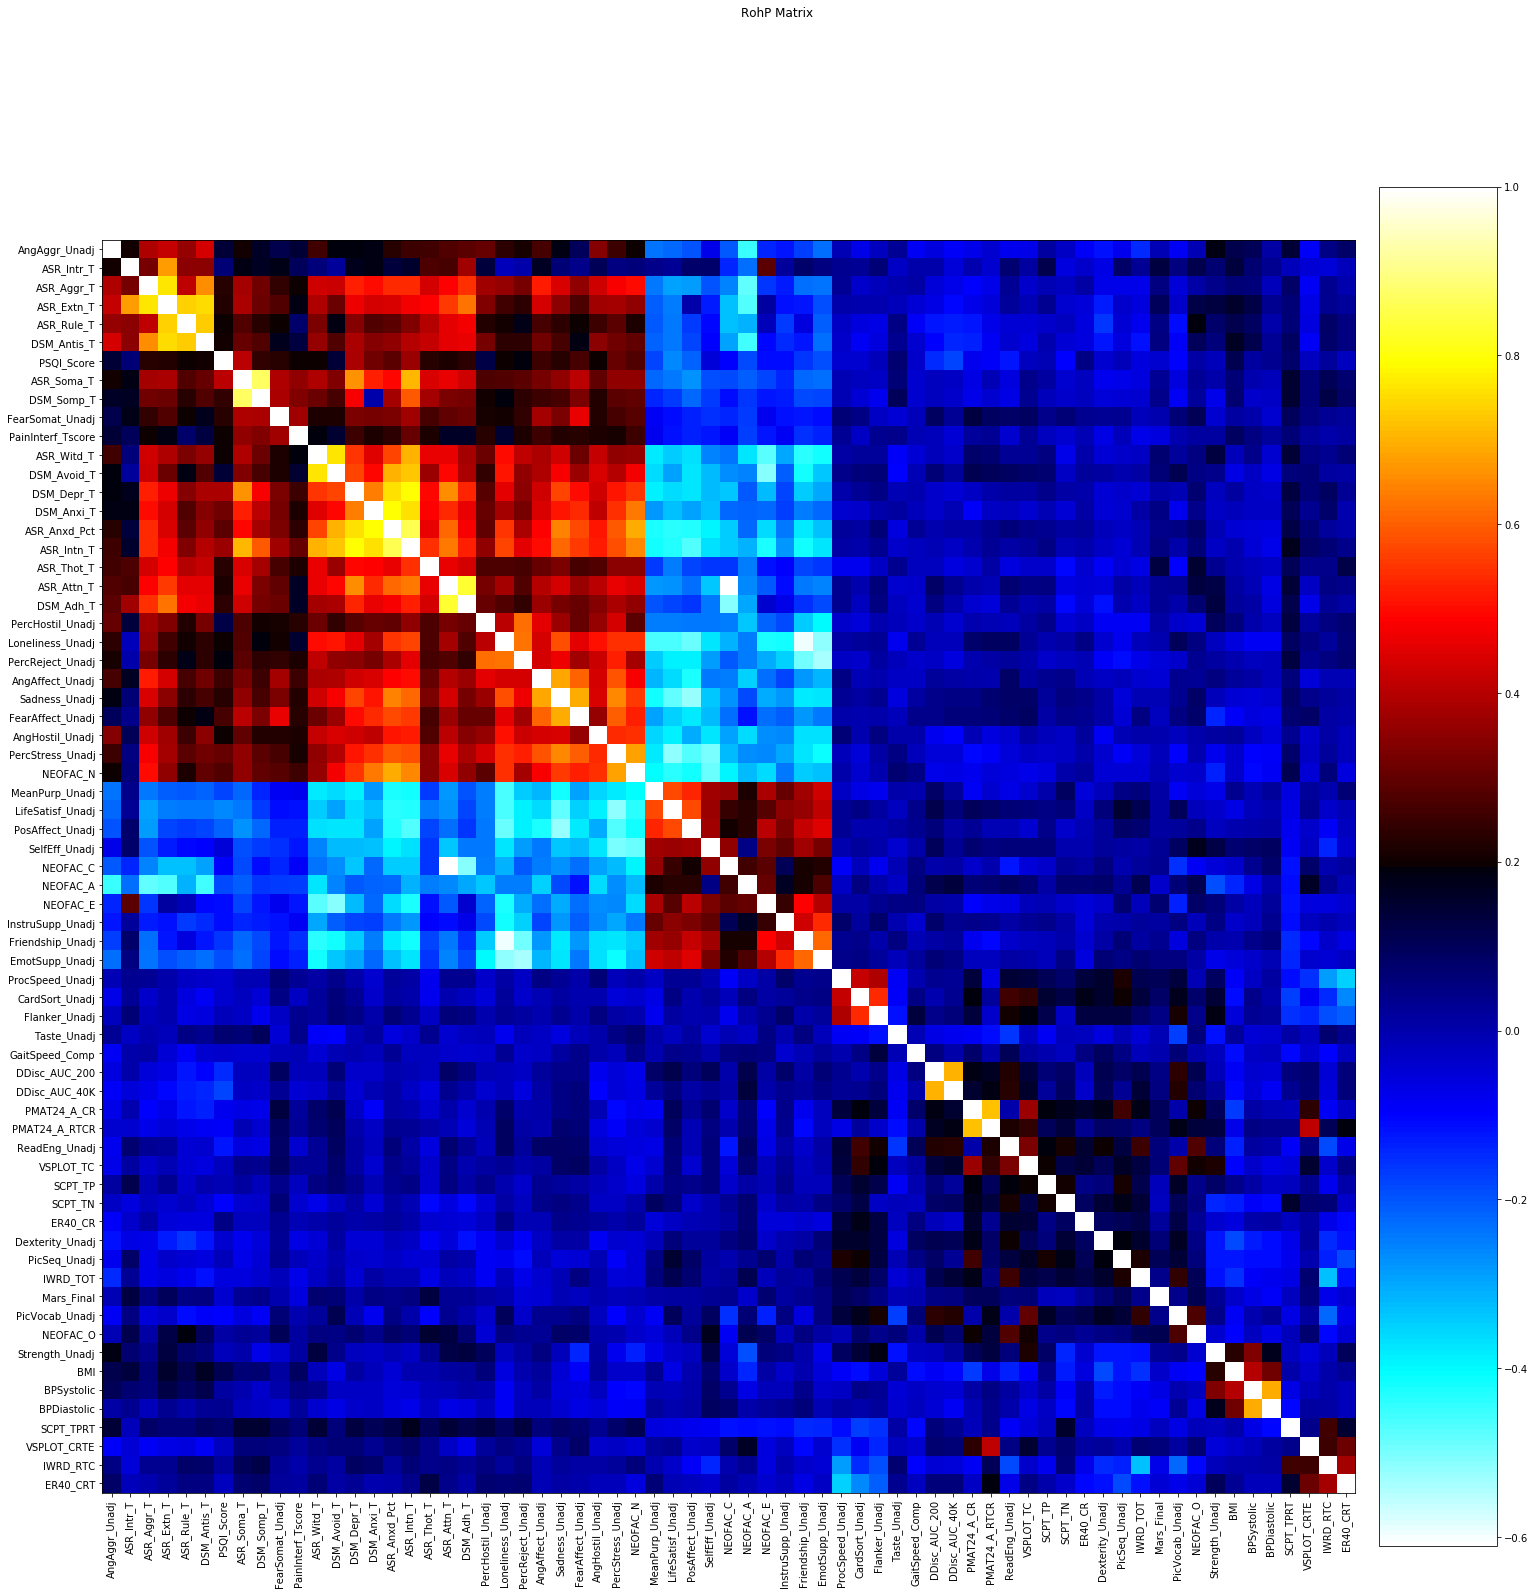

In [84]:
# Plot the RhoP matrix again, but now ordered by hierarchy
use_columns = pheno_clean_df.columns.drop('ID')
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(RohP[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RohP Matrix')

In [85]:
%%octave -o sil,hier,ind_s,val_s -i RohP,n_sbt

hier = niak_hierarchical_clustering(RohP,struct('flag_verbose',false)); # replication the hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',30)); # Cut the hierarchy to get clusters
sil = niak_build_avg_silhouette (RohP,hier);
[val_s,ind_s] = niak_find_local_max_1d(2:30,sil(1:29))

     Percentage done : 0 6 11 15 21 26 30 36 41 45 50 56 61 65 71 76 80 86 91 95 Done ! 

val_s =

   0.25587

   0.14814

ind_s =

    2

   13

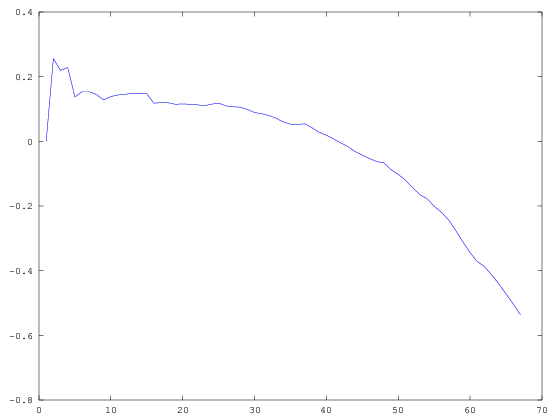

In [86]:
%octave plot(sil)

### Plot silouhette

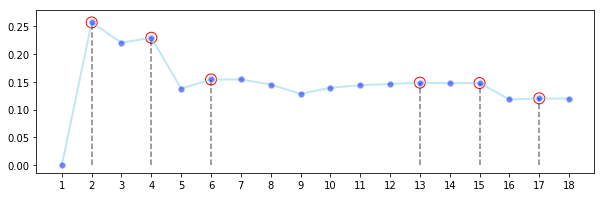

In [87]:
# plot silhouette figure
from scipy.signal import find_peaks
# trunck it first
sil_trunc = [ss[0] for ss in sil][:18]
plt.figure(figsize=(10,3))

# plot silhouette
plt.plot(np.arange(1,len(sil_trunc)+1),sil_trunc, marker='o',
         markerfacecolor='blue',alpha = 0.5,
         markersize=6, color='skyblue', linewidth=2)

# Find peaks
peaks, _ = find_peaks(sil_trunc, height=0)

# plot peaks on top of silhouette
plt.scatter(peaks+1,[sil_trunc[x]  for x in peaks], s=120, facecolors='none', edgecolors='r')
plt.vlines(peaks+1,0,[sil_trunc[x]  for x in peaks],linestyle='--',alpha = 0.5)
plt.xticks(np.arange(1,len(sil_trunc)+1, step=1));
plt.savefig(os.path.join(path_root,'Figures/behavioral/silhouette_RhoP_1200.svg'))

In [88]:
# Order clustered correlation matrix
RohP_clust = RohP[order, :][:, order]
RohP_p_fd_clust = RohP_p_fd[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

In [89]:
# Generate boxes
matP, cmatP, lmatP, indP = make_boxes(RohP_clust, cuts, 1)
matP_fd, cmatP_fd, lmatP_fd, indP_fd = make_boxes(RohP_p_fd_clust, cuts, 1)

#### RhoP 

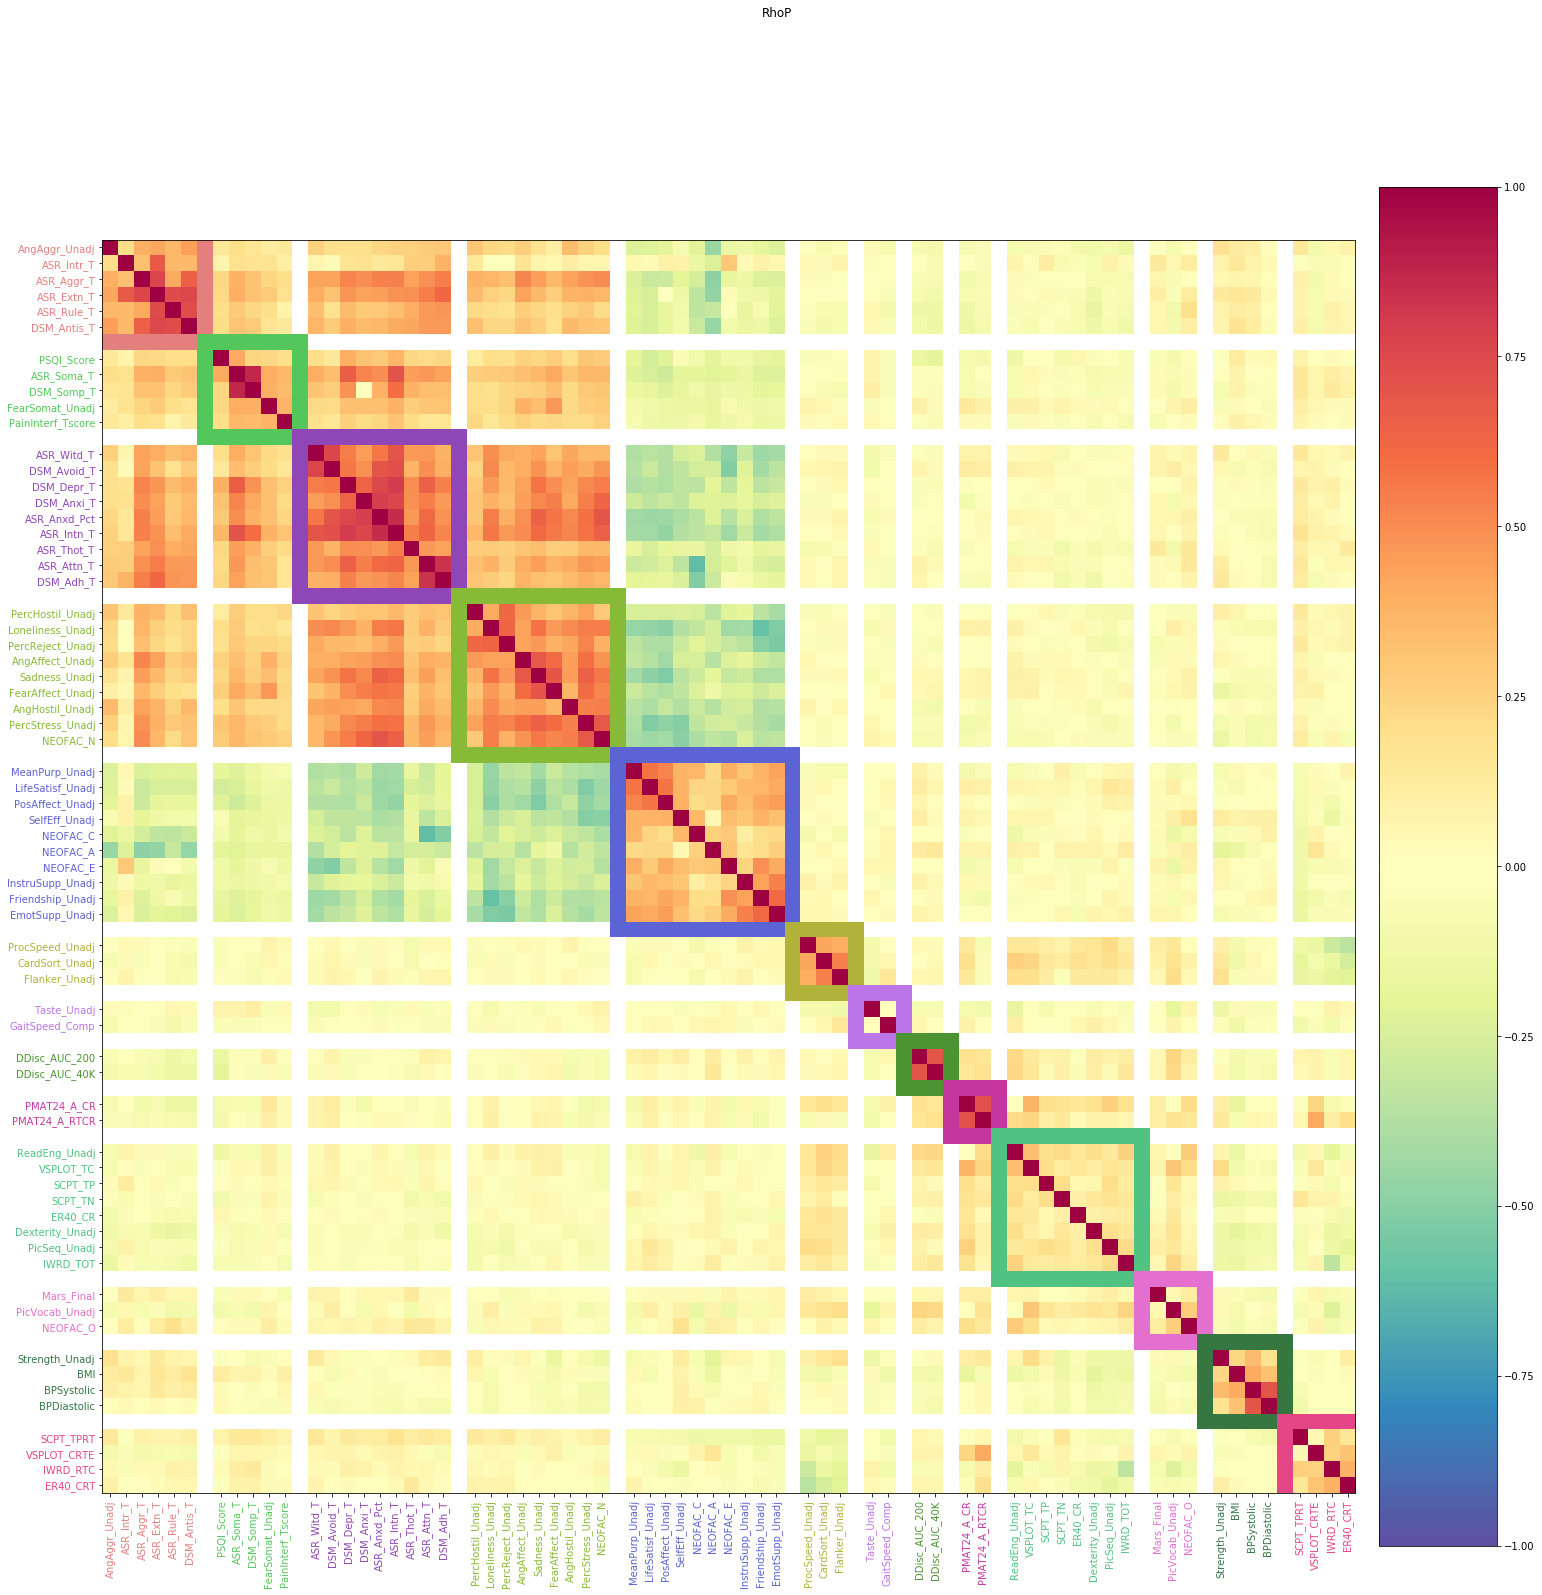

In [90]:
# Set figure
lin,color_list = clusters_color(n_sbt)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matP, cmap=plt.cm.Spectral_r,interpolation='nearest', vmin=-1, vmax=1)
tmp = ax.imshow(lmatP, cmap=plt.cm.Greys_r,interpolation='nearest')
tmp = ax.imshow(lmatP, cmap=plt.cm.Greys, alpha=1,interpolation='nearest')
tmp = ax.imshow(cmatP, cmap=lin,interpolation='nearest')
tmp = ax.set_yticks(indP)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indP)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [color_list[i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoP')
f.savefig(os.path.join(path_root,'Figures/behavioral/RhoP_clustered_{}_1200.svg'.format(n_sbt)))

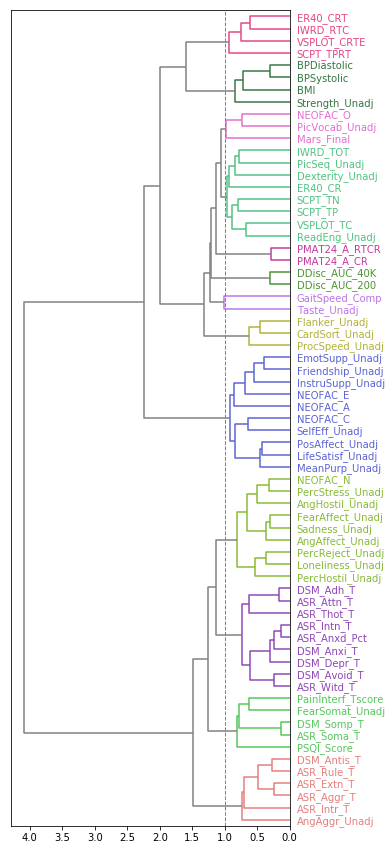

In [103]:
fig = plt.figure(figsize=(5, 15))
link = scl.hierarchy.linkage(dist, method='ward')
scl.hierarchy.set_link_color_palette(color_list)

dn = scl.hierarchy.dendrogram(link,labels=pheno_clean_df.columns.drop('ID'),
                              leaf_rotation=0,
                              orientation="left",
                              color_threshold=1.05,
                              above_threshold_color='grey',
                              leaf_font_size = '10')
plt.axvline(x=1, c='grey', lw=1, linestyle='dashed')

# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=colors[num]
    lbl.set_color(val)
fig.savefig(os.path.join(path_root,'Figures/behavioral/dendrogram_cluster_RhoP_{}_1200.svg'.format(n_sbt)))

#### RhoP pval

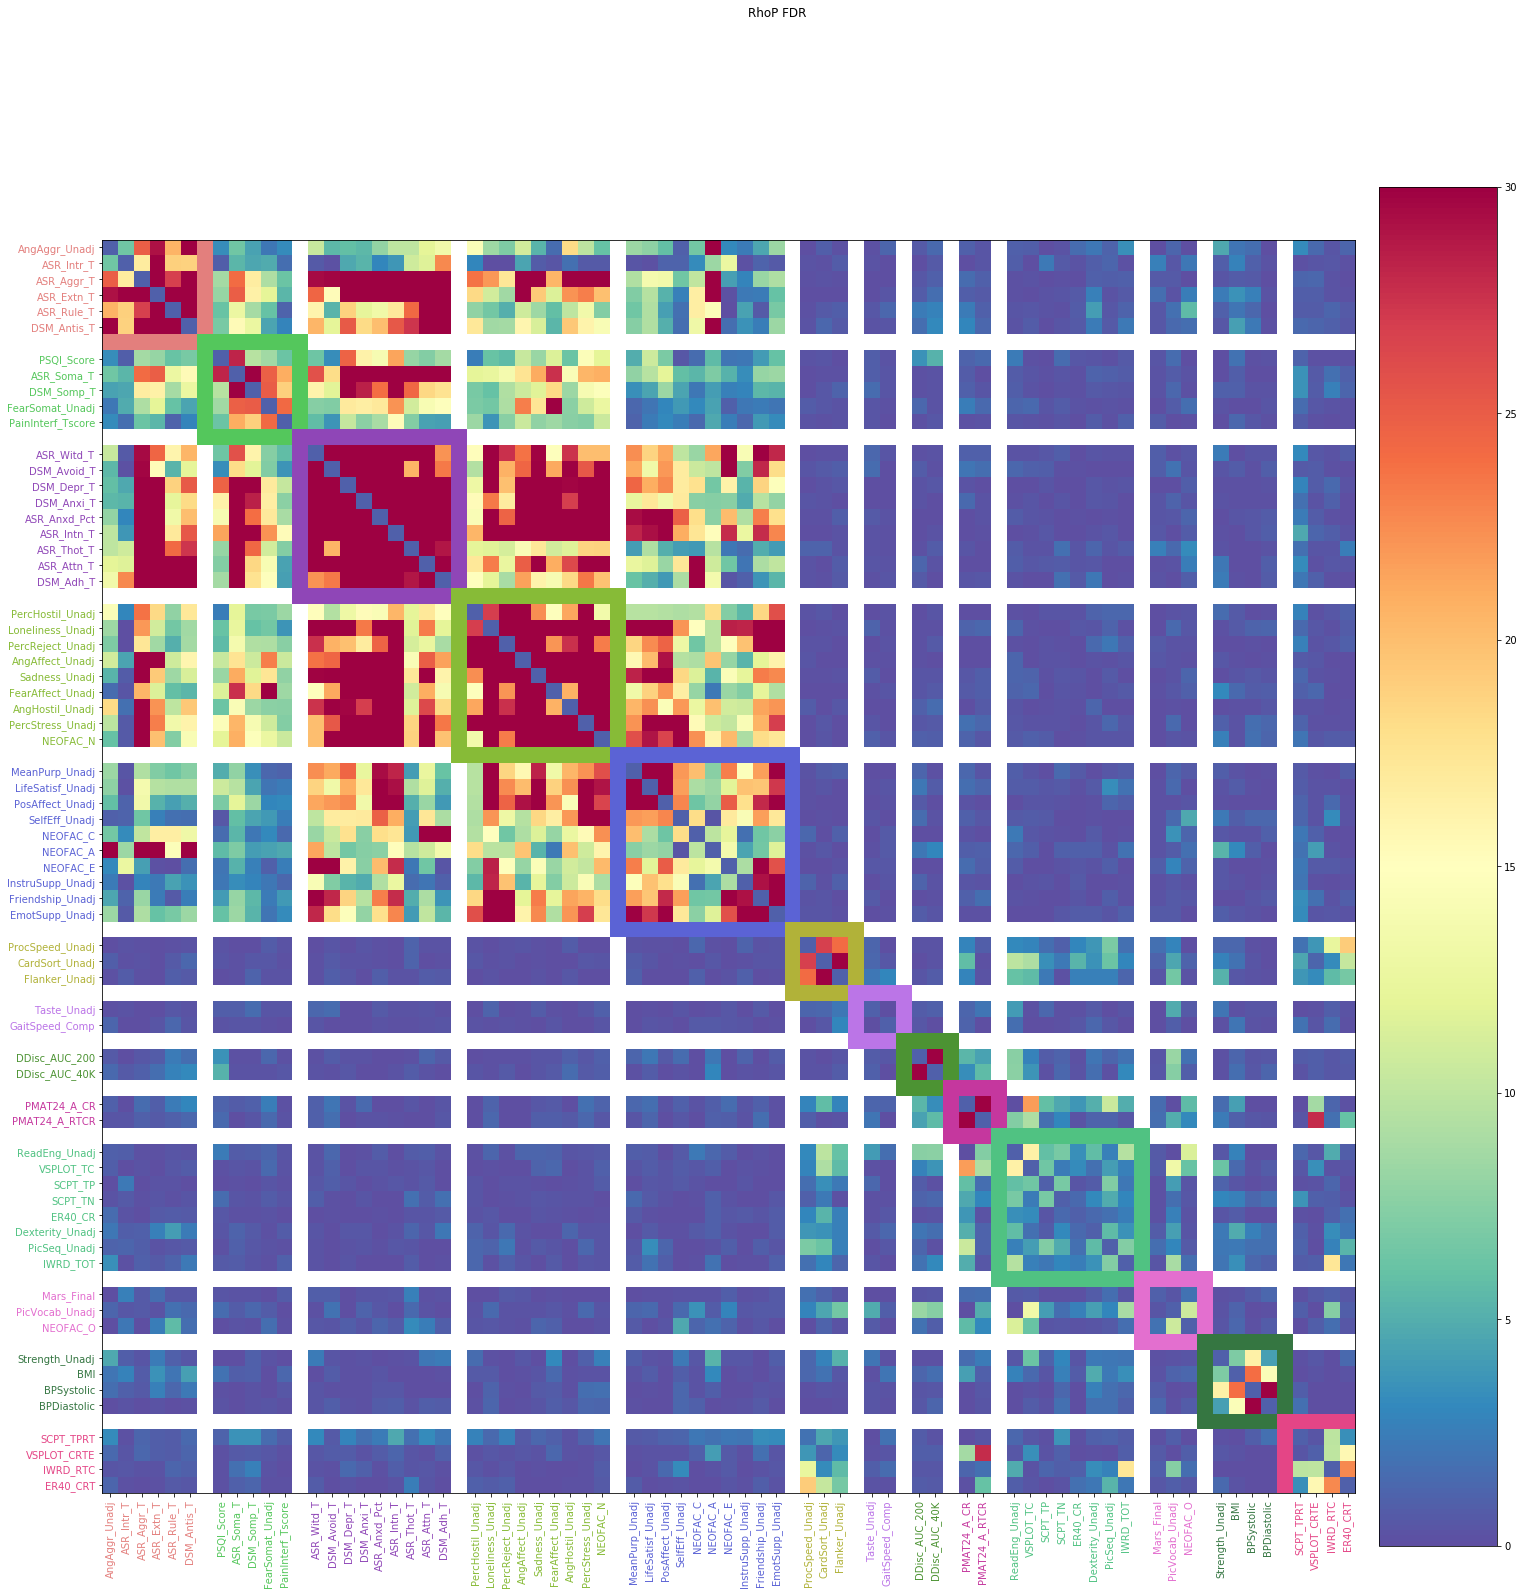

In [104]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matP_fd, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=30)
tmp = ax.imshow(lmatP_fd, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmatP_fd, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmatP_fd, cmap=lin,interpolation='none')
tmp = ax.set_yticks(indP_fd)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indP_fd)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [color_list[i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoP FDR')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

In [106]:
# Make a new pheno table with the average scores of these bootstraped pheno
data = np.array([np.mean(pheno_df[[use_columns[x] for x in np.where(part==sid)[0]]],1) for sid in np.unique(part)])
inde_x = pheno_df.index
col_names = ['Cluster_{}'.format(x) for x in np.unique(part)]
sbt_pheno_bootstrap = pd.DataFrame(data=data.T, columns=col_names, index=inde_x)
merged_pheno_clust_bootstrap = pd.merge(pheno_df[["ID"]], sbt_pheno_bootstrap, how='right', left_index=True, right_index=True)
path_pheno = '/mnt/home_sq/yassinebha/data/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/pheno'
merged_pheno_clust_bootstrap.to_csv(os.path.join(path_pheno,'hcp_pleio_RhoP_pheno_nonan_norm_python_13_1200.csv'), index=False)

In [107]:
dict_clusters = {'Cluster_1' : 'Desord_ext',
                 'Cluster_2' : 'Somatic',
                 'Cluster_3' : 'Desord_int',
                 'Cluster_4' : 'Neg_affec',
                 'Cluster_5' : 'Pos_affetc',
                 'Cluster_6' : 'Self_regul',
                 'Cluster_7' : 'Fluid_intel',
                 'Cluster_8' : 'Mem_att_mot',
                 'Cluster_9' : 'Academic_comp',
                 'Cluster_10' : 'Executive',
                 'Cluster_11' : 'Sens_Emo_Fit',
                 'Cluster_12' : 'Physio',
                 'Cluster_13' : 'Speed'}

In [108]:
# Here are the groups I found:
for sid in np.unique(part):
    match_cols = [use_columns[x] for x in np.where(part==sid)[0]]
    print('Cluster_{} :'.format(sid))
    for col in match_cols:
        print('    {}'.format(col))

Cluster_1 :
    AngAggr_Unadj
    ASR_Aggr_T
    ASR_Rule_T
    ASR_Intr_T
    ASR_Extn_T
    DSM_Antis_T
Cluster_2 :
    PSQI_Score
    FearSomat_Unadj
    PainInterf_Tscore
    ASR_Soma_T
    DSM_Somp_T
Cluster_3 :
    ASR_Anxd_Pct
    ASR_Witd_T
    ASR_Thot_T
    ASR_Attn_T
    ASR_Intn_T
    DSM_Depr_T
    DSM_Anxi_T
    DSM_Avoid_T
    DSM_Adh_T
Cluster_4 :
    Sadness_Unadj
    FearAffect_Unadj
    AngHostil_Unadj
    AngAffect_Unadj
    Loneliness_Unadj
    PercHostil_Unadj
    PercReject_Unadj
    PercStress_Unadj
    NEOFAC_N
Cluster_5 :
    LifeSatisf_Unadj
    MeanPurp_Unadj
    PosAffect_Unadj
    Friendship_Unadj
    EmotSupp_Unadj
    InstruSupp_Unadj
    SelfEff_Unadj
    NEOFAC_A
    NEOFAC_C
    NEOFAC_E
Cluster_6 :
    CardSort_Unadj
    Flanker_Unadj
    ProcSpeed_Unadj
Cluster_7 :
    Taste_Unadj
    GaitSpeed_Comp
Cluster_8 :
    DDisc_AUC_200
    DDisc_AUC_40K
Cluster_9 :
    PMAT24_A_CR
    PMAT24_A_RTCR
Cluster_10 :
    PicSeq_Unadj
    ReadEng_Unadj
    VSPLOT

In [109]:
Cluster 1 has the following variables:
    DDisc_AUC_200
    DDisc_AUC_40K
Cluster 2 has the following variables:
    BMI
    BPSystolic
    BPDiastolic
Cluster 3 has the following variables:
    CardSort_Unadj
    Flanker_Unadj
    ProcSpeed_Unadj
Cluster 4 has the following variables:
    Sadness_Unadj
    FearAffect_Unadj
    AngHostil_Unadj
    AngAffect_Unadj
    Loneliness_Unadj
    PercHostil_Unadj
    PercReject_Unadj
    PercStress_Unadj
    NEOFAC_N
Cluster 5 has the following variables:
    PSQI_Score
    FearSomat_Unadj
    PainInterf_Tscore
    ASR_Soma_Pct
    DSM_Somp_Pct
Cluster 6 has the following variables:
    VSPLOT_CRTE
    SCPT_TPRT
    IWRD_RTC
    ER40_CRT
Cluster 7 has the following variables:
    AngAggr_Unadj
    ASR_Aggr_Pct
    ASR_Rule_Pct
    ASR_Intr_Pct
    ASR_Extn_T
    DSM_Antis_Pct
Cluster 8 has the following variables:
    Endurance_Unadj
    Strength_Unadj
Cluster 9 has the following variables:
    LifeSatisf_Unadj
    MeanPurp_Unadj
    PosAffect_Unadj
    Friendship_Unadj
    EmotSupp_Unadj
    InstruSupp_Unadj
    SelfEff_Unadj
    NEOFAC_A
    NEOFAC_C
    NEOFAC_E
Cluster 10 has the following variables:
    PicSeq_Unadj
    SCPT_TP
    SCPT_TN
    IWRD_TOT
    ER40_CR
    Dexterity_Unadj
Cluster 11 has the following variables:
    ASR_Anxd_Pct
    ASR_Witd_Pct
    ASR_Thot_Pct
    ASR_Attn_Pct
    ASR_Intn_T
    DSM_Depr_Pct
    DSM_Anxi_Pct
    DSM_Avoid_Pct
    DSM_Adh_Pct
Cluster 12 has the following variables:
    Handedness
    Taste_Unadj
    Odor_Unadj
    Mars_Final
    GaitSpeed_Comp
Cluster 13 has the following variables:
    SSAGA_Educ
    PMAT24_A_CR
    PMAT24_A_RTCR
    ReadEng_Unadj
    PicVocab_Unadj
    VSPLOT_TC
    NEOFAC_O

SyntaxError: invalid syntax (<ipython-input-109-ecff2c9703e5>, line 1)